## **A Predictive Analytics Framework for Profitability Analysis**


In [1]:
##  CAPSTONE_2: A Predictive Analytics Framework for Profitability Analysis
 #   Movement classification, upsell & cross-sell recommendations with next-month projected profit.

#### **STEP 1: DATA UNDERSTANDING:**

Data_101-2.xlsx : (30-04-2020 to 30-06-2025)

First sheet:(55,752 rows) Rich transaction log—has invoice number and Customer_Id plus all product-level fields such as incoice date, product id, first date(launch date), category id, inv quantity, ass_value(represents revenue which also includes discounts and so on). This is the primary fact source since it links to customers.

Second sheet: (4,535 rows): Product id with Most_Common_Unit_Price. This is our single source of truth for price—no price from revenue.

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

XLSX = "/content/drive/MyDrive/capstone2/Data_101-2.xlsx"

# to set sheet names
# tx = pd.read_excel(XLSX, sheet_name="full_data", engine="openpyxl")
# price = pd.read_excel(XLSX, sheet_name="Most common unit price", engine="openpyxl")

# to make sure about sheet names, auto-detect:
sheets = pd.read_excel(XLSX, sheet_name=None, engine="openpyxl")
tx, price = None, None
for name, df in sheets.items():
    cols = [c.lower().strip() for c in df.columns]
    if set(["product_id","most_common_unit_price"]) <= set([c.replace(" ", "_") for c in cols]):
        price = df
    else:
        # look for transaction headers
        if {"invoice_no","invoice_date","product_id","first_date","category_id","inv_quantity","ass_value","cid"} \
           <= set([c.lower().strip() for c in df.columns]):
            tx = df

if tx is None or price is None:
    raise ValueError("Couldn’t identify both sheets. Check column names and sheet order.")

print("Transactions shape:", tx.shape)
print("Price list shape:", price.shape)


Transactions shape: (55751, 8)
Price list shape: (4535, 2)


#### **STEP 2: DATA PREPROCESSING:**

Data preprocessing was performed to clean and structure the raw data for further analysis.

- Normalized column names & types; parsed dates day-first; ids to string; numerics to float/int.
- Left-joined price list as Fixed_Unit_Price.
- Filled any missing revenue only when both Qty and Price were present (no price back-calculation).
- Wrote the cleaned table to master_clean.csv.

here, first we define a function before we call it(to re-run the logic(rebuild) without re-loading files every time)


thus, it guarantees consistent grain and types, avoids leakage from “reverse-engineering” prices.

In [ ]:
# DATA PREPROCESSING


import numpy as np
import pandas as pd

#  1) Column normalization
def _normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Map messy headers to a single clean schema and ensure required columns exist."""
    m = {
        "Invoice_No":"Invoice_Number", "invoice_no":"Invoice_Number",
        "Invoice_Date":"Invoice_Date","invoice_date":"Invoice_Date",
        "Product_Id":"Product_Id","product_id":"Product_Id",
        "first_date":"Launch_Date","First_Date":"Launch_Date",
        "category_Id":"Category_Id","Category_Id":"Category_Id","category_id":"Category_Id",
        "Inv_Quantity":"Invoice_Quantity","inv_quantity":"Invoice_Quantity",
        "ass_Value":"Revenue","ass_value":"Revenue",
        "CID":"Customer_Id","cid":"Customer_Id",
        "Most_Common_Unit_Price":"Most_Common_Unit_Price","most_common_unit_price":"Most_Common_Unit_Price"
    }
    out = df.copy()
    out.columns = [m.get(c, c) for c in out.columns]
    for c in ["Invoice_Number","Invoice_Date","Product_Id","Customer_Id",
              "Category_Id","Launch_Date","Invoice_Quantity","Revenue"]:
        if c not in out.columns:
            out[c] = pd.NA
    return out

#  2) Type casting & basic row validity
def _cast_tx(df: pd.DataFrame) -> pd.DataFrame:
    """Parse dates (dayfirst), cast IDs to string, numerics to float, drop invalid rows."""
    x = df.copy()

    x["Invoice_Date"] = pd.to_datetime(x["Invoice_Date"], errors="coerce", dayfirst=True)
    x["Launch_Date"]  = pd.to_datetime(x["Launch_Date"],  errors="coerce", dayfirst=True)

    for c in ["Product_Id","Customer_Id","Invoice_Number","Category_Id"]:
        if c in x.columns:
            x[c] = x[c].astype("string")

    x["Invoice_Quantity"] = pd.to_numeric(x["Invoice_Quantity"], errors="coerce")
    x["Revenue"]          = pd.to_numeric(x["Revenue"], errors="coerce")

    # keep only rows with a valid date + product, and positive quantity
    x = x.dropna(subset=["Invoice_Date","Product_Id"]).copy()
    x = x[x["Invoice_Quantity"].fillna(0) > 0]

    # normalized date for grouping
    x["Invoice_Date_only"] = x["Invoice_Date"].dt.normalize()
    return x

#  3) Roll up duplicates / split lines (NOT drop)
def _rollup_lines(df: pd.DataFrame) -> pd.DataFrame:
    """
    Consolidate potential duplicate/split lines:
    - If Invoice_Number present: group by [Invoice_Number, Invoice_Date_only, Product_Id, Customer_Id, Category_Id]
    - Else: group by [Invoice_Date_only, Product_Id, Customer_Id, Category_Id]
    - Sum Invoice_Quantity and Revenue (Revenue sum keeps NaN if all NaN), keep earliest Launch_Date.
    """
    x = df.copy()

    if "Invoice_Date_only" not in x.columns:
        x["Invoice_Date_only"] = pd.to_datetime(x["Invoice_Date"], errors="coerce").dt.normalize()

    # robust check: not null and not a literal "nan"/"NaN"/blank
    inv_str = x["Invoice_Number"].astype("string").str.strip().str.lower()
    has_inv = x["Invoice_Number"].notna() & inv_str.ne("nan") & inv_str.ne("")

    grp_with_inv = ["Invoice_Number","Invoice_Date_only","Product_Id","Customer_Id","Category_Id"]
    grp_no_inv   = ["Invoice_Date_only","Product_Id","Customer_Id","Category_Id"]

    def _roll(df_part: pd.DataFrame, grp_cols: list[str]) -> pd.DataFrame:
        # build agg map dynamically from available cols
        agg = {}
        if "Launch_Date" in df_part.columns:       agg["Launch_Date"]       = "min"
        if "Invoice_Quantity" in df_part.columns:  agg["Invoice_Quantity"]  = "sum"
        if "Revenue" in df_part.columns:           agg["Revenue"]           = lambda s: s.sum(min_count=1)
        # stable representatives for IDs/dates
        for c in ["Invoice_Date","Invoice_Number","Product_Id","Customer_Id","Category_Id"]:
            if c in df_part.columns: agg[c] = "first"

        out = (df_part
               .sort_values(["Invoice_Date","Product_Id"])
               .groupby([c for c in grp_cols if c in df_part.columns], as_index=False)
               .agg(agg))
        return out

    a = x[has_inv]
    b = x[~has_inv]

    a_out = _roll(a, grp_with_inv) if not a.empty else a
    b_out = _roll(b, grp_no_inv)   if not b.empty else b

    out = pd.concat([a_out, b_out], ignore_index=True, sort=False)

    # keep normalized date for later joins if needed
    if "Invoice_Date_only" not in out.columns and "Invoice_Date" in out.columns:
        out["Invoice_Date_only"] = pd.to_datetime(out["Invoice_Date"], errors="coerce").dt.normalize()

    return out

#  4) Attach fixed price from reference sheet
def _attach_price(tx: pd.DataFrame, price_df: pd.DataFrame) -> pd.DataFrame:
    p = _normalize_cols(price_df.copy())

    if "Product_Id" not in p.columns:
        raise ValueError("Price sheet is missing Product_Id.")
    if "Most_Common_Unit_Price" not in p.columns:
        raise ValueError("Price sheet is missing Most_Common_Unit_Price.")

    p["Product_Id"] = p["Product_Id"].astype("string")
    p["Most_Common_Unit_Price"] = pd.to_numeric(p["Most_Common_Unit_Price"], errors="coerce")

    out = tx.merge(p[["Product_Id","Most_Common_Unit_Price"]], on="Product_Id", how="left")
    out = out.rename(columns={"Most_Common_Unit_Price":"Fixed_Unit_Price"})
    out["Price_Flag"] = np.where(out["Fixed_Unit_Price"].notna(), "price_ref", "missing_price_ref")
    return out

# 5) Strict revenue fill (NO price from revenue)
def _fill_revenue_strict(df: pd.DataFrame) -> pd.DataFrame:
    x = df.copy()
    mask = x["Revenue"].isna() & x["Invoice_Quantity"].notna() & x["Fixed_Unit_Price"].notna()
    x.loc[mask, "Revenue"] = x.loc[mask, "Invoice_Quantity"] * x.loc[mask, "Fixed_Unit_Price"]
    x["Revenue_Fill_Flag"] = np.where(mask, "filled_from_fixed_price", "as_is")
    return x

# 6) check: show groups that were rolled up
def audit_rollups(df: pd.DataFrame) -> pd.DataFrame:
    """Return groups with >1 raw lines that were consolidated."""
    x = df.copy()
    if "Invoice_Date_only" not in x.columns:
        x["Invoice_Date_only"] = pd.to_datetime(x["Invoice_Date"], errors="coerce").dt.normalize()
    inv_str = x["Invoice_Number"].astype("string").str.strip().str.lower()
    has_inv = x["Invoice_Number"].notna() & inv_str.ne("nan") & inv_str.ne("")

    grp_with_inv = ["Invoice_Number","Invoice_Date_only","Product_Id","Customer_Id","Category_Id"]
    grp_no_inv   = ["Invoice_Date_only","Product_Id","Customer_Id","Category_Id"]

    a = (x[has_inv].groupby(grp_with_inv, as_index=False).size().rename(columns={"size":"rows_in_group"}))
    b = (x[~has_inv].groupby(grp_no_inv,   as_index=False).size().rename(columns={"size":"rows_in_group"}))

    audit = pd.concat([a,b], ignore_index=True, sort=False)
    return audit[audit["rows_in_group"] > 1].sort_values("rows_in_group", ascending=False)


# BUILD MASTER
# ( already read tx (transactions) and price (price reference) dataframes)


# 1) Normalize and cast
tx_norm  = _normalize_cols(tx)
tx_cast  = _cast_tx(tx_norm)

# 2) Roll up split/duplicate lines (keyed by invoice/date/product/customer/category)
tx_roll  = _rollup_lines(tx_cast)

# 3) Attach fixed price; keep policy: NEVER compute price from revenue
tx_prc   = _attach_price(tx_roll, price)

# 4) Strict revenue fill using fixed price
master   = _fill_revenue_strict(tx_prc)

# 5) Tidy columns, order, and basic checks
keep = ["Invoice_Number","Invoice_Date","Product_Id","Launch_Date","Customer_Id",
        "Category_Id","Invoice_Quantity","Revenue","Fixed_Unit_Price",
        "Price_Flag","Revenue_Fill_Flag"]
master = (master[keep]
          .sort_values(["Invoice_Date","Product_Id"])
          .reset_index(drop=True))

print("master rows:", len(master))
print("date range:", master["Invoice_Date"].min().date(), "→", master["Invoice_Date"].max().date())
print("price coverage (%):", round(master["Fixed_Unit_Price"].notna().mean()*100, 2))
print("missing customer id (%):", round(master["Customer_Id"].isna().mean()*100, 2))

#  CHECK the consolidation
rolled = audit_rollups(tx_cast)
print("groups consolidated (>1 raw lines):", len(rolled))

# 6) Save
MASTER_OUT = "/content/drive/MyDrive/capstone2/master_clean.csv"
master.to_csv(MASTER_OUT, index=False)
print("saved:", MASTER_OUT)


master rows: 51484
date range: 2020-04-30 → 2025-06-30
price coverage (%): 100.0
missing customer id (%): 0.0
groups consolidated (>1 raw lines): 3438
saved: /content/drive/MyDrive/capstone2/master_clean.csv


#### **STEP 3: BUILD THE MONTHLY DATAMART (fact + dims + baskets)**

- Rolled transactions to monthly grain; built fact_sales_monthly.csv.
- Normalized YM_Date to the first of month.
- Kept dims (dim_product.csv collapsed to 1 row per product).
- Prepared baskets_monthly.csv for market-basket rules.

Thus, All models forecast next month, so month-level consistency is mandatory.

In [ ]:
# MONTHLY DATAMART


In [ ]:
# build monthly datamart, save

import re
import pandas as pd
import numpy as np

# 1) Header repair: strip hidden chars, map all aliases/variants to  exact schema
def normalize_headers(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # remove BOM / zero-width / NBSP and trim
    def clean_token(s):
        s = str(s).replace("\ufeff","").replace("\u200b","").replace("\xa0"," ")
        return s.strip()

    out.columns = [clean_token(c) for c in out.columns]

    # canonical key for matching
    def key(s: str) -> str:
        return re.sub(r"[^a-z0-9]", "", s.lower())

    alias = {
        # exact schema on the right side
        "invoicenumber": "Invoice_Number",
        "invoicedate": "Invoice_Date",
        "productid": "Product_Id",
        "launchdate": "Launch_Date",
        "customerid": "Customer_Id",
        "customer_id": "Customer_Id",
        "cid": "Customer_Id",
        "categoryid": "Category_Id",
        "invoicequantity": "Invoice_Quantity",
        "invquantity": "Invoice_Quantity",
        "revenue": "Revenue",
        "assvalue": "Revenue",
        "fixedunitprice": "Fixed_Unit_Price",
        "priceflag": "Price_Flag",
        "revenuefillflag": "Revenue_Fill_Flag",
        # sometimes  saved CSV keeps underscores → cover those too
        "invoice_date": "Invoice_Date",
        "product_id": "Product_Id",
        "category_id": "Category_Id",
        "invoice_quantity": "Invoice_Quantity",
        "fixed_unit_price": "Fixed_Unit_Price",
    }

    mapped = []
    for c in out.columns:
        k = key(c)
        mapped.append(alias.get(k, c))
    out.columns = mapped

    # coalesce if two columns mapped to the same final name
    counts = pd.Series(out.columns).value_counts()
    dup_names = counts[counts > 1].index.tolist()
    for name in dup_names:
        cols = [i for i, col in enumerate(out.columns) if col == name]
        series = out.iloc[:, cols[0]]
        for idx in cols[1:]:
            series = series.combine_first(out.iloc[:, idx])
        out[name] = series
        # drop the extra duplicate columns
        keep_idx = [i for i in range(out.shape[1]) if not (out.columns[i] == name and i not in [cols[0]])]
        out = out.iloc[:, keep_idx]

    return out

def build_monthly_mart(master: pd.DataFrame):
    # normalize headers first
    print("HEADERS (raw):", list(master.columns))
    m = normalize_headers(master)
    print("HEADERS (final):", list(m.columns))

    # ensure required columns exist
    need = ["Invoice_Number","Invoice_Date","Product_Id","Launch_Date","Customer_Id",
            "Category_Id","Invoice_Quantity","Revenue","Fixed_Unit_Price"]
    for c in need:
        if c not in m.columns:
            m[c] = pd.NA

    # types
    m["Invoice_Date"] = pd.to_datetime(m["Invoice_Date"], errors="coerce")
    if "Launch_Date" in m.columns:
        m["Launch_Date"] = pd.to_datetime(m["Launch_Date"], errors="coerce")
    for c in ["Customer_Id","Product_Id","Category_Id"]:
        if c in m.columns:
            m[c] = m[c].astype("string")
    m["Invoice_Quantity"] = pd.to_numeric(m["Invoice_Quantity"], errors="coerce")
    m["Revenue"]          = pd.to_numeric(m["Revenue"], errors="coerce")

    # month keys
    m["YearMonth"] = m["Invoice_Date"].dt.to_period("M").astype(str)
    m["YM_Date"]   = pd.to_datetime(m["YearMonth"] + "-01", errors="coerce")

    # monthly fact (Customer × Product × Month)
    fact = (m.groupby(["Customer_Id","Product_Id","YearMonth","YM_Date"], as_index=False)
              .agg(Month_Quantity=("Invoice_Quantity","sum"),
                   Month_Revenue =("Revenue","sum"),
                   Fixed_Unit_Price=("Fixed_Unit_Price","max"))
              .sort_values(["Customer_Id","Product_Id","YM_Date"])
              .reset_index(drop=True))

    # leak-free rollings
    def _add_rollings(g):
        g = g.sort_values("YM_Date")
        g["Qty_MA3"]    = g["Month_Quantity"].rolling(3, min_periods=1).mean().shift(1)
        g["Qty_MA6"]    = g["Month_Quantity"].rolling(6, min_periods=1).mean().shift(1)
        g["Rev_MA3"]    = g["Month_Revenue"].rolling(3, min_periods=1).mean().shift(1)
        g["Rev_MA6"]    = g["Month_Revenue"].rolling(6, min_periods=1).mean().shift(1)
        g["Qty_Trend3"] = g["Month_Quantity"].diff(3).shift(1)
        return g

    fact = fact.groupby(["Customer_Id","Product_Id"], group_keys=False).apply(_add_rollings)
    for c in ["Qty_MA3","Qty_MA6","Rev_MA3","Rev_MA6","Qty_Trend3"]:
        fact[c] = fact[c].fillna(0.0)

    # dimensions
    dim_product = (m[["Product_Id","Fixed_Unit_Price","Category_Id","Launch_Date"]]
                   .drop_duplicates().sort_values("Product_Id").reset_index(drop=True))
    dim_customer = (m.loc[m["Customer_Id"].notna(), ["Customer_Id"]]
                      .drop_duplicates()
                      .sort_values("Customer_Id")
                      .reset_index(drop=True))
    dim_date = (fact[["YearMonth","YM_Date"]]
                .drop_duplicates()
                .sort_values("YM_Date")
                .reset_index(drop=True))
    dim_date["Year"]  = dim_date["YM_Date"].dt.year
    dim_date["Month"] = dim_date["YM_Date"].dt.month

    # baskets per customer-month
    baskets = (fact.loc[fact["Customer_Id"].notna()]
                    .groupby(["Customer_Id","YearMonth"], as_index=False)["Product_Id"]
                    .apply(lambda s: sorted(set(s))))
    baskets = baskets.rename(columns={"Product_Id":"Basket_List"})
    baskets["Basket_Size"]  = baskets["Basket_List"].apply(len)
    baskets["Basket_Items"] = baskets["Basket_List"].apply(lambda lst: "|".join(lst))
    baskets = baskets[["Customer_Id","YearMonth","Basket_Size","Basket_Items"]]

    quick = {
        "fact_rows": len(fact),
        "date_min": dim_date["YM_Date"].min(),
        "date_max": dim_date["YM_Date"].max(),
        "customers": dim_customer.shape[0],
        "products": dim_product.shape[0],
        "months": dim_date.shape[0],
    }
    return fact, dim_date, dim_product, dim_customer, baskets, quick

#  Load without parse_dates ( inside), run, save
master = pd.read_csv("/content/drive/MyDrive/capstone2/master_clean.csv", low_memory=False)

fact_m, d_date, d_prod, d_cust, baskets_m, quick = build_monthly_mart(master)
print("monthly fact:", fact_m.shape)
print("date range:", quick["date_min"].date(), "→", quick["date_max"].date())
print("customers:", quick["customers"], "| products:", quick["products"], "| months:", quick["months"])

fact_m.to_csv("/content/drive/MyDrive/capstone2/fact_sales_monthly.csv", index=False)
d_date.to_csv("/content/drive/MyDrive/capstone2/dim_date.csv", index=False)
d_prod.to_csv("/content/drive/MyDrive/capstone2/dim_product.csv", index=False)
d_cust.to_csv("/content/drive/MyDrive/capstone2/dim_customer.csv", index=False)
baskets_m.to_csv("/content/drive/MyDrive/capstone2/baskets_monthly.csv", index=False)
print("saved fact/dims/baskets to Drive.")


HEADERS (raw): ['Invoice_Number', 'Invoice_Date', 'Product_Id', 'Launch_Date', 'Customer_Id', 'Category_Id', 'Invoice_Quantity', 'Revenue', 'Fixed_Unit_Price', 'Price_Flag', 'Revenue_Fill_Flag']
HEADERS (final): ['Invoice_Number', 'Invoice_Date', 'Product_Id', 'Launch_Date', 'Customer_Id', 'Category_Id', 'Invoice_Quantity', 'Revenue', 'Fixed_Unit_Price', 'Price_Flag', 'Revenue_Fill_Flag']


/tmp/ipython-input-3593626970.py:113: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fact = fact.groupby(["Customer_Id","Product_Id"], group_keys=False).apply(_add_rollings)


monthly fact: (41814, 12)
date range: 2020-04-01 → 2025-06-01
customers: 1112 | products: 5306 | months: 63
saved fact/dims/baskets to Drive.


**Output Observation:**

Monthly fact: (41,814, 12)

Date range: 2020-04-01 → 2025-06-01

Customers: 1,112 | Products: 5,306 | Months: 63

Minor pandas warning from a groupby().apply (not harmful).

#### **STEP 4: EXPLORATORY DATA ANALYSIS**


In [ ]:
# EXPLORATORY DATA ANALYSIS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def ensure_month_col(df, date_col="Invoice_Date", out_month_col="YearMonth", out_first_of_month_col="YM_Date"):
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
    out[out_month_col] = out[date_col].dt.to_period("M").astype(str)
    out[out_first_of_month_col] = pd.to_datetime(out[out_month_col] + "-01")
    return out

def save_show(plt_obj, outpath: Path):
    outpath.parent.mkdir(parents=True, exist_ok=True)
    plt_obj.tight_layout()
    plt_obj.savefig(outpath, dpi=120, bbox_inches="tight")
    plt_obj.show()

def eda_volume_over_time(fact_monthly: pd.DataFrame, outdir: Path):
    df = fact_monthly.copy()
    df = df.groupby("YM_Date", as_index=False).agg(
        Total_Qty=("Month_Quantity","sum"),
        Total_Revenue=("Month_Revenue","sum")
    ).sort_values("YM_Date")
    # quantity line
    fig = plt.figure()
    plt.plot(df["YM_Date"], df["Total_Qty"])
    plt.title("Quantity per Month")
    plt.xlabel("Month")
    plt.ylabel("Total Quantity")
    plt.show()
    #save_show(plt, outdir / "eda_qty_per_month.png")
    # revenue line
    fig = plt.figure()
    plt.plot(df["YM_Date"], df["Total_Revenue"])
    plt.title("Revenue per Month")
    plt.xlabel("Month")
    plt.ylabel("Total Revenue")
    plt.show()
    #save_show(plt, outdir / "eda_revenue_per_month.png")
    df.to_csv(outdir / "volume_over_time.csv", index=False)
    return {
        "months": len(df),
        "qty_min": float(df["Total_Qty"].min()),
        "qty_max": float(df["Total_Qty"].max()),
        "rev_min": float(df["Total_Revenue"].min()),
        "rev_max": float(df["Total_Revenue"].max()),
        "date_min": df["YM_Date"].min(),
        "date_max": df["YM_Date"].max(),
    }

def eda_top_products_categories(master: pd.DataFrame, topn_products=15, topn_categories=10, outdir: Path = Path(".")):
    m = master.copy()
    m = ensure_month_col(m, "Invoice_Date")
    # top products by revenue (all time)
    prod = (m.groupby("Product_Id", as_index=False)
              .agg(Total_Revenue=("Revenue","sum"),
                   Total_Qty=("Invoice_Quantity","sum")))
    prod = prod.sort_values("Total_Revenue", ascending=False)
    prod.head(topn_products).to_csv(outdir / "top_products.csv", index=False)

    # bar chart: top products by revenue
    tp = prod.head(topn_products)
    fig = plt.figure(figsize=(10,4))
    plt.bar(tp["Product_Id"].astype(str), tp["Total_Revenue"])
    plt.title(f"Top {topn_products} Products by Revenue (All Time)")
    plt.xlabel("Product_Id")
    plt.ylabel("Revenue")
    plt.xticks(rotation=60, ha="right")
    plt.show()
    #save_show(plt, outdir / "eda_top_products.png")

    # top categories by revenue (all time) if category present
    if "Category_Id" in m.columns:
        cat = (m.groupby("Category_Id", as_index=False)
                 .agg(Total_Revenue=("Revenue","sum"),
                      Total_Qty=("Invoice_Quantity","sum"))
                 .sort_values("Total_Revenue", ascending=False))
        cat.head(topn_categories).to_csv(outdir / "top_categories.csv", index=False)

        fig = plt.figure(figsize=(8,4))
        topc = cat.head(topn_categories)
        plt.bar(topc["Category_Id"].astype(str), topc["Total_Revenue"])
        plt.title(f"Top {topn_categories} Categories by Revenue (All Time)")
        plt.xlabel("Category_Id")
        plt.ylabel("Revenue")
        plt.xticks(rotation=45, ha="right")
        plt.show()
        #save_show(plt, outdir / "eda_top_categories.png")
    else:
        cat = pd.DataFrame(columns=["Category_Id","Total_Revenue","Total_Qty"])

    return {"top_products_rows": int(min(len(prod), topn_products)),
            "top_categories_rows": int(min(len(cat), topn_categories))}

def eda_new_vs_repeat(master: pd.DataFrame, outdir: Path):
    # new = customer's first-ever month; repeat = active customers minus new that month
    m = ensure_month_col(master, "Invoice_Date")  # adds YearMonth (str) and YM_Date (first-of-month datetime)
    m = m.dropna(subset=["Customer_Id"]).copy()
    # first month per customer (as YM_Date)
    first = (m.groupby("Customer_Id", as_index=False)["YM_Date"].min()
               .rename(columns={"YM_Date":"First_YM"}))
    # active customers per YM_Date
    active = (m.groupby(["YM_Date"], as_index=False)["Customer_Id"].nunique()
                .rename(columns={"Customer_Id":"Active_Customers"}))
    # new customers per YM_Date
    new = (first.groupby("First_YM", as_index=False)["Customer_Id"].count()
                 .rename(columns={"First_YM":"YM_Date","Customer_Id":"New_Customers"}))
    # merge on YM_Date so keys match
    monthly = active.merge(new, on="YM_Date", how="left").fillna({"New_Customers":0})
    monthly["Repeat_Customers"] = monthly["Active_Customers"] - monthly["New_Customers"]

    # plot
    fig = plt.figure()
    plt.plot(monthly["YM_Date"], monthly["Active_Customers"], label="Active")
    plt.plot(monthly["YM_Date"], monthly["New_Customers"], label="New")
    plt.plot(monthly["YM_Date"], monthly["Repeat_Customers"], label="Repeat")
    plt.title("New vs Repeat Customers per Month")
    plt.xlabel("Month")
    plt.ylabel("Customers")
    plt.legend()
    plt.show()
    # save_show(plt, outdir / "eda_new_vs_repeat.png")
    monthly.to_csv(outdir / "new_vs_repeat_customers.csv", index=False)
    return {
        "months": int(len(monthly)),
        "active_max": int(monthly["Active_Customers"].max()),
        "new_max": int(monthly["New_Customers"].max()),
        "repeat_max": int(monthly["Repeat_Customers"].max())}


def eda_demand_distribution(fact_monthly: pd.DataFrame, outdir: Path):
    # distribution of total demand per product
    p = (fact_monthly.groupby("Product_Id", as_index=False)
                      .agg(Total_Qty=("Month_Quantity","sum"),
                           Total_Revenue=("Month_Revenue","sum"))
                      .sort_values("Total_Qty", ascending=False))

    # histogram of quantities
    fig = plt.figure()
    plt.hist(p["Total_Qty"], bins=40)
    plt.title("Distribution of Total Quantity per Product (All Time)")
    plt.xlabel("Total Quantity")
    plt.ylabel("Count of Products")
    plt.show()
    #save_show(plt, outdir / "eda_product_qty_distribution.png")

    # histogram of revenue
    fig = plt.figure()
    plt.hist(p["Total_Revenue"], bins=40)
    plt.title("Distribution of Total Revenue per Product (All Time)")
    plt.xlabel("Total Revenue")
    plt.ylabel("Count of Products")
    plt.show()
    #save_show(plt, outdir / "eda_product_revenue_distribution.png")

    p.to_csv(outdir / "product_totals.csv", index=False)
    return {"products": int(len(p)),
            "qty_median": float(p["Total_Qty"].median()),
            "rev_median": float(p["Total_Revenue"].median())}

def eda_pareto(fact_monthly: pd.DataFrame, outdir: Path, top_pct=0.20):
    # cumulative share of revenue by product
    pr = (fact_monthly.groupby("Product_Id", as_index=False)["Month_Revenue"]
                      .sum()
                      .rename(columns={"Month_Revenue":"Revenue"})
                      .sort_values("Revenue", ascending=False)
                      .reset_index(drop=True))
    pr["Cum_Revenue"] = pr["Revenue"].cumsum()
    total_rev = pr["Revenue"].sum()
    pr["Cum_Share"] = pr["Cum_Revenue"] / total_rev if total_rev > 0 else 0.0

    # share contributed by top X% products
    k = max(1, int(round(top_pct * len(pr))))
    share_top = pr.iloc[:k]["Revenue"].sum() / total_rev if total_rev > 0 else 0.0

    fig = plt.figure()
    plt.plot(np.arange(1, len(pr)+1) / len(pr), pr["Cum_Share"])
    plt.title("Pareto Curve: Cumulative Revenue Share by Product")
    plt.xlabel("Fraction of Products (sorted by revenue)")
    plt.ylabel("Cumulative Revenue Share")
    plt.show()
    #save_show(plt, outdir / "eda_pareto_curve.png")

    pr.to_csv(outdir / "pareto_by_product.csv", index=False)
    return {"products": int(len(pr)),
            "share_top_20pct_products": float(round(share_top*100, 2))}

def eda_churn_signals(fact_monthly: pd.DataFrame, outdir: Path, topn=30):
    # use last observed month; mark (cust,prod) as declining if MA3 < MA6 and trend negative
    f = fact_monthly.copy().sort_values(["Customer_Id","Product_Id","YM_Date"])
    last_date = f["YM_Date"].max()
    latest = f.groupby(["Customer_Id","Product_Id"], as_index=False).tail(1)
    latest = latest[latest["YM_Date"] == last_date].copy()

    latest["Declining"] = (latest["Qty_MA3"] < latest["Qty_MA6"]) & (latest["Qty_Trend3"] < 0)
    rate_decline = float((latest["Declining"].mean() * 100.0) if len(latest) else 0.0)

    # top products by number of declining customer-pairs
    by_prod = (latest[latest["Declining"]]
               .groupby("Product_Id", as_index=False)["Declining"].sum()
               .rename(columns={"Declining":"Declining_Customers"})
               .sort_values("Declining_Customers", ascending=False))
    by_prod.to_csv(outdir / "decline_by_product.csv", index=False)

    # bar chart for top products (if any)
    if not by_prod.empty:
        fig = plt.figure(figsize=(10,4))
        top = by_prod.head(topn)
        plt.bar(top["Product_Id"].astype(str), top["Declining_Customers"])
        plt.title(f"Products with Most Declining Customers (as of {pd.to_datetime(last_date).date()})")
        plt.xlabel("Product_Id")
        plt.ylabel("# Declining Customers")
        plt.xticks(rotation=60, ha="right")
        plt.show()
        #save_show(plt, outdir / "eda_declining_products.png")

    latest[["Customer_Id","Product_Id","Qty_MA3","Qty_MA6","Qty_Trend3","Declining"]].to_csv(outdir / "decline_flags_latest_month.csv", index=False)
    return {"latest_month": pd.to_datetime(last_date),
            "pairs_total": int(len(latest)),
            "pairs_declining_pct": float(round(rate_decline, 2))}

def eda_basket_size(baskets_monthly: pd.DataFrame, outdir: Path):
    b = baskets_monthly.copy()
    if "Basket_Size" not in b.columns and "Basket_Items" in b.columns:
        b["Basket_Size"] = b["Basket_Items"].fillna("").apply(lambda s: 0 if s=="" else len(str(s).split("|")))
    fig = plt.figure()
    plt.hist(b["Basket_Size"], bins=20)
    plt.title("Basket Size Distribution (Customer-Month)")
    plt.xlabel("Basket Size")
    plt.ylabel("Count of Customer-Months")
    plt.show()
    #save_show(plt, outdir / "eda_basket_size_distribution.png")

    summary = {
        "rows": int(len(b)),
        "basket_mean": float(b["Basket_Size"].mean()),
        "basket_median": float(b["Basket_Size"].median()),
        "basket_max": int(b["Basket_Size"].max() if len(b) else 0)
    }
    pd.DataFrame([summary]).to_csv(outdir / "basket_size_summary.csv", index=False)
    b.to_csv(outdir / "baskets_monthly_checked.csv", index=False)
    return summary


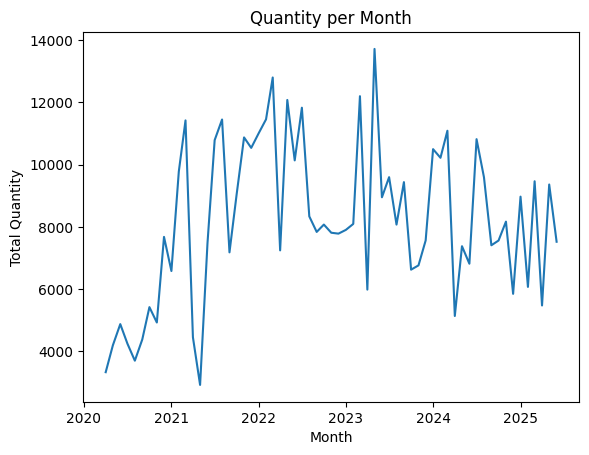

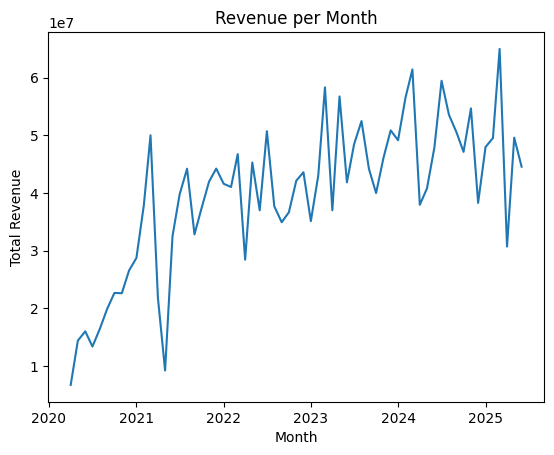

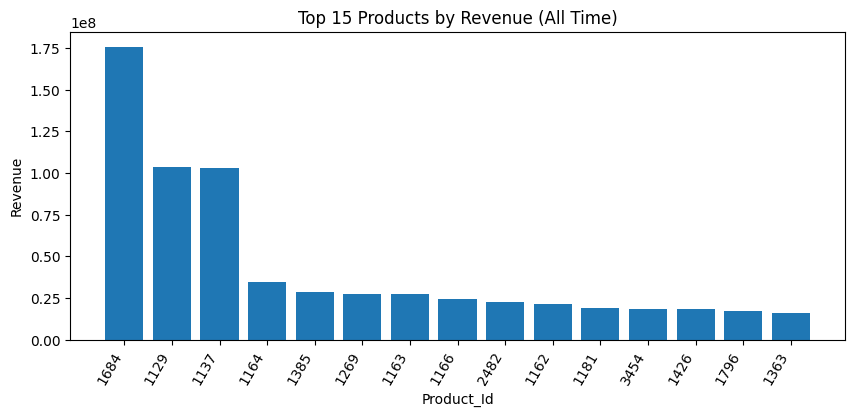

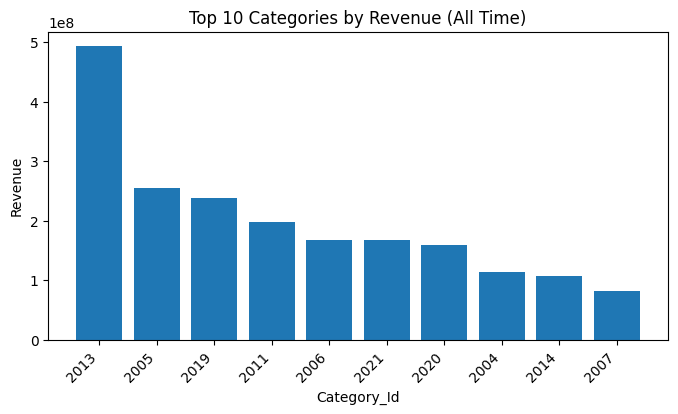

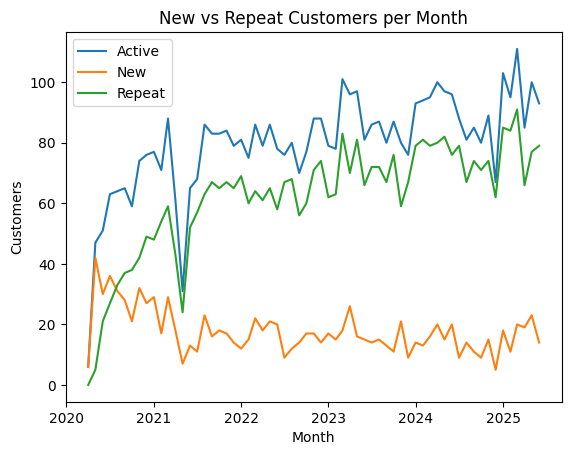

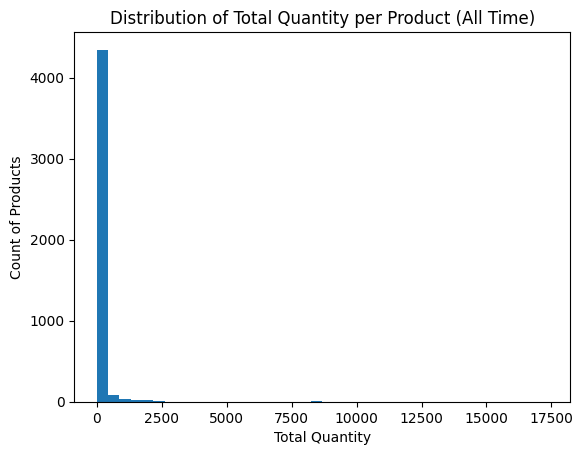

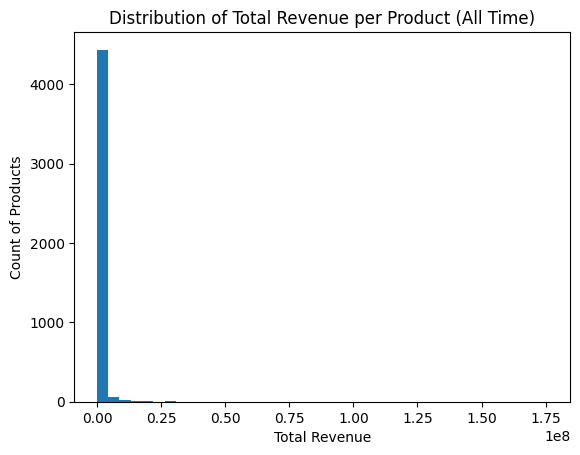

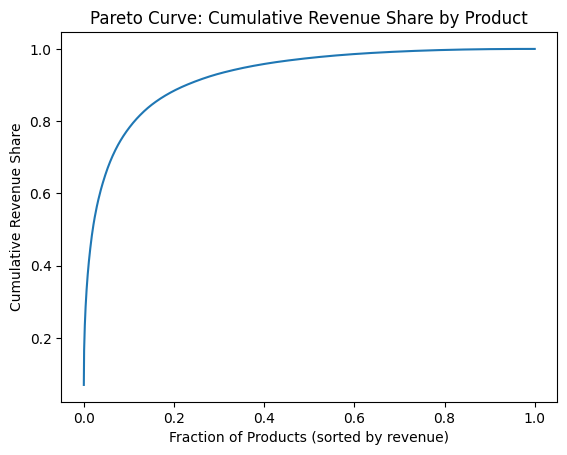

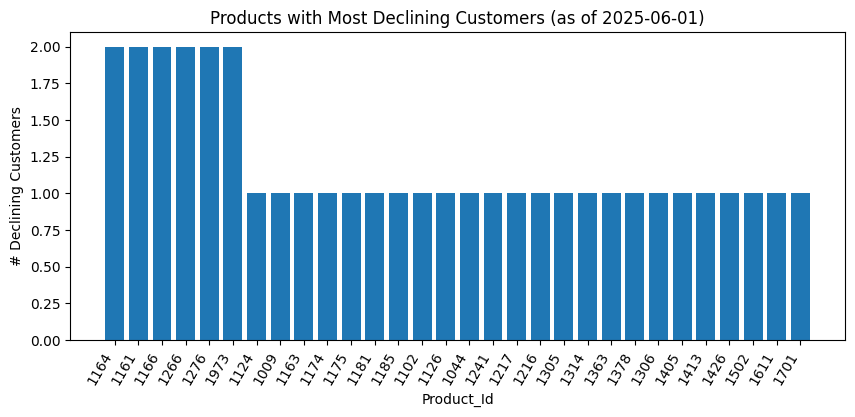

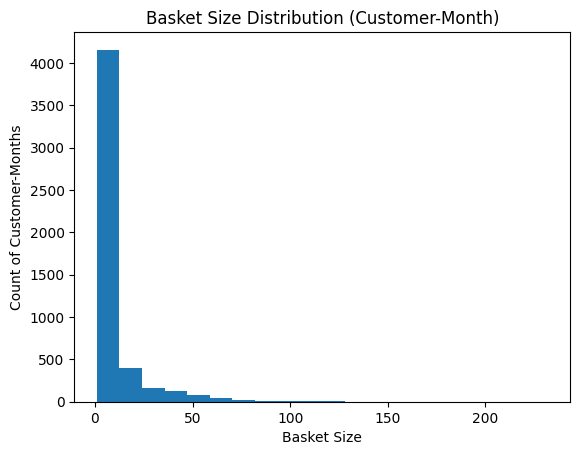

saved outputs to: /content/drive/MyDrive/capstone2/eda_outputs


In [ ]:
# RUN EDA on saved files and save outputs

import pandas as pd
from pathlib import Path

BASE = Path("/content/drive/MyDrive/capstone2")
OUT  = BASE / "eda_outputs"
OUT.mkdir(parents=True, exist_ok=True)

# Load data
fact_m = pd.read_csv(BASE / "fact_sales_monthly.csv", parse_dates=["YM_Date"], low_memory=False)
for c in ["Customer_Id","Product_Id"]:
    if c in fact_m.columns: fact_m[c] = fact_m[c].astype("string")

master = pd.read_csv(BASE / "master_clean.csv",
                     parse_dates=["Invoice_Date","Launch_Date"], low_memory=False)
for c in ["Customer_Id","Product_Id","Category_Id"]:
    if c in master.columns: master[c] = master[c].astype("string")

# Baskets (load or quick build)
try:
    baskets_m = pd.read_csv(BASE / "baskets_monthly.csv", low_memory=False)
except FileNotFoundError:
    temp = (fact_m.groupby(["Customer_Id","YearMonth"], as_index=False)["Product_Id"]
                 .apply(lambda s: sorted(set(s))))
    temp = temp.rename(columns={"Product_Id":"Basket_List"})
    temp["Basket_Size"]  = temp["Basket_List"].apply(len)
    temp["Basket_Items"] = temp["Basket_List"].apply(lambda lst: "|".join(lst))
    baskets_m = temp[["Customer_Id","YearMonth","Basket_Size","Basket_Items"]]
    baskets_m.to_csv(BASE / "baskets_monthly.csv", index=False)

# Run EDA
vol   = eda_volume_over_time(fact_m, OUT)
tops  = eda_top_products_categories(master, topn_products=15, topn_categories=10, outdir=OUT)
nvr   = eda_new_vs_repeat(master, OUT)
dist  = eda_demand_distribution(fact_m, OUT)
pareto= eda_pareto(fact_m, OUT, top_pct=0.20)
churn = eda_churn_signals(fact_m, OUT, topn=30)
bask  = eda_basket_size(baskets_m, OUT)

summary = {**vol, **tops, **nvr, **dist, **pareto, **churn, **bask}
pd.DataFrame([summary]).to_csv(OUT / "eda_summary_overview.csv", index=False)
print("saved outputs to:", OUT)


**Output Observation:**

1. Quantity per Month

logic: I grouped the fact table by YM_Date and summed the column Month_Quantity across all customer-product pairs.

X-axis: Months from April 2020 to June 2025.

Y-axis: Total units sold across all products in that month.

It shows:
- We see how overall demand fluctuates over time.
- Peaks represent high sales seasons or campaigns, while dips might indicate lean months.
- This one gives us demand seasonality and volatility.

2. Revenue per Month

logic: Same grouping, but summing Month_Revenue.

X-axis: Months from 2020–2025.

Y-axis: Total revenue per month.

It shows:
- Tracks the financial performance of the company month by month.
- Revenue may spike even if quantity does not (due to high-value products).
- Useful for identifying cycles, trends, and dips in cash inflow.

3. Top 15 Products by Revenue

logic: Grouped by Product_Id, summed revenue over the entire dataset, and sorted descending.

X-axis: Top 15 product IDs.

Y-axis: Total revenue from each product.

It shows:
- A handful of products dominate revenue.
- Product 1684 alone generates ~1.75×10⁸ revenue, much higher than others.
- This highlights core revenue drivers and helps focus future campaigns on these products.

4. Top 10 Categories by Revenue

logic: Similar aggregation but at Category_Id level.

X-axis: Top 10 categories.

Y-axis: Total revenue.

It shows:
- Category 2013 is by far the strongest revenue generator (~5×10⁸).
- Other categories contribute moderately.
- This tells us which product families matter most for profit uplift strategies.

5. New vs Repeat Customers per Month

logic:

For each customer, identify the first month (First_YM).

A customer is “new” if that month = their first appearance.

Otherwise, they are “repeat”.

Active = total unique customers that month.

X-axis: Months.

Y-axis: Number of customers.

Blue = active, Orange = new, Green = repeat.

It shows:
- Growth of customer base over time.
- Whether business relies more on new acquisition or repeat retention.
- A healthy business shows repeat customers increasing steadily, which this graph confirms.

6. Distribution of Total Quantity per Product

logic: Group by Product_Id and sum Month_Quantity across all months.

X-axis: total units sold (per product lifetime).

Y-axis: count of products that fall into that bucket.

It shows:
- Most products sell in very low volumes.
- Only a few products reach very high demand (long-tail effect).
- Inventory strategy must handle slow-moving vs fast-moving products differently.

7. Distribution of Total Revenue per Product

logic: sum Month_Revenue.

X-axis: total revenue per product.

Y-axis: number of products.

It shows:
- Similar long-tail effect in revenue.
- Most products contribute little, but a handful dominate sales revenue.

8. Pareto Curve (Cumulative Revenue Share by Product)

logic: Sort products by revenue, compute cumulative share.

X-axis: fraction of products (sorted by revenue).

Y-axis: cumulative revenue share.

It shows:
- Classic Pareto principle: ~20% of products drive ~80% of total revenue.
- Curve is steep at the start, then flattens—showing concentration of sales in a few SKUs.
- Strategic takeaway: focus marketing and stock on top 20% SKUs.

9. Products with Most Declining Customers (latest month)

logic (decline detection):

For each Customer × Product, take the latest month available (June 2025) and calculate:

Qty_MA3 = average monthly quantity over last 3 months (shifted to avoid leakage).

Qty_MA6 = average monthly quantity over last 6 months.

Qty_Trend3 = difference in demand compared to 3 months earlier.

A customer-product pair is flagged as “declining” if:

Qty_MA3 < Qty_MA6 → short-term demand is weaker than long-term demand.

Qty_Trend3 < 0 → the actual demand is trending downward.

X-axis: product IDs.

Y-axis: number of customers showing decline for that product.

It shows:
- Products with many declining customers are at risk of churn.
- Eg: If Product 1164 has 2 customers flagged, it means both conditions held true for those customers in June 2025.
-So decline is not random; it is a structured signal based on comparing short-term vs long-term averages and recent trend.

10. Basket Size Distribution (Customer-Month)

logic: For each customer and month, count the distinct products purchased (Basket_Size).

X-axis: basket size (number of unique products bought in a month).

Y-axis: how many customer-months fall in that bucket.

It shows:
- Most baskets are small (1–5 items).
- Some customers buy very large baskets (50–200 items).
- This matters for cross-sell, because larger baskets show higher openness to try multiple products.

#### **STEP 5: FEATURE ENGINEERING**

- Build features for upsell, cross sell, movement.

In [ ]:
# FEATURE ENGINEERING

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path


# Helpers

def parse_items(s):
    if pd.isna(s) or s == "":
        return []
    return str(s).split("|")

def month_diff(a: pd.Series, b: pd.Series) -> pd.Series:
    return (a.dt.year - b.dt.year) * 12 + (a.dt.month - b.dt.month)

def recency_from_qty(q: pd.Series) -> pd.Series:
    out = []; r = np.nan
    for v in q.fillna(0).values:
        if v > 0:
            r = 0
        else:
            r = r + 1 if not np.isnan(r) else np.nan
        out.append(r)
    return pd.Series(out, index=q.index, dtype="float")


##### **Cross sell rules**

- Built pair rules from monthly baskets with support ≥ 2%, confidence ≥ 30%, lift ≥ 1.2.
- De-duplicated symmetric pairs, kept strongest direction.

In [ ]:
# Cross-sell rules

def build_pair_rules(baskets_df: pd.DataFrame, min_support=0.02, min_conf=0.30, min_lift=1.20):
    tx = [sorted(set(parse_items(s))) for s in baskets_df["Basket_Items"].fillna("")]
    tx = [t for t in tx if len(t) >= 2]
    n = len(tx)
    if n == 0:
        return pd.DataFrame(columns=["A","B","support","confidence","lift","count_pair","count_A","count_B"])

    from collections import Counter
    item_c = Counter(); pair_c = Counter()
    for t in tx:
        item_c.update(t)
        for a in t:
            for b in t:
                if a != b:
                    pair_c[(a,b)] += 1

    rows=[]
    for (a,b), cab in pair_c.items():
        ca, cb = item_c[a], item_c[b]
        sup  = cab / n
        conf = cab / ca if ca else 0.0
        supb = cb / n
        lift = (conf / supb) if supb else 0.0
        if sup >= min_support and conf >= min_conf and lift >= min_lift:
            rows.append({"A":a,"B":b,"support":sup,"confidence":conf,"lift":lift,
                         "count_pair":cab,"count_A":ca,"count_B":cb})
    out = (pd.DataFrame(rows)
             .sort_values(["lift","confidence","support"], ascending=False)
             .reset_index(drop=True))
    if not out.empty:
        out["_pair"] = out.apply(lambda r: tuple(sorted([str(r["A"]), str(r["B"])])), axis=1)
        out = out.drop_duplicates("_pair").drop(columns="_pair").reset_index(drop=True)
    return out


##### **Movement (Product×Month; densified calendar)**

- For each product and each calendar month (including zero-sales months), computed:
   - Lags (Qty/Rev L1/L3/L6), rolling means/std (past-only), growth rates, recency, months since launch.
- Target move_y (for next month): 0=To-Zero, 1=Drop (≤-10%), 2=Steady (±10%), 3=Rise (≥+10%).

In [ ]:
# Product movement features (Product × Month)

def build_product_movement_features(fact_monthly: pd.DataFrame, dim_product: pd.DataFrame):
    base = (fact_monthly.groupby(["Product_Id","YM_Date"], as_index=False)
            .agg(Month_Quantity=("Month_Quantity","sum"),
                 Month_Revenue =("Month_Revenue","sum"))
            .copy())
    base["YM_Date"] = pd.to_datetime(base["YM_Date"], errors="coerce")

    # Calendar range
    min_month = base["YM_Date"].min().to_period("M").to_timestamp()
    max_month = base["YM_Date"].max().to_period("M").to_timestamp()
    all_months = pd.date_range(min_month, max_month, freq="MS")

    # Collapse dim_product to single row per Product_Id
    p = dim_product[["Product_Id","Fixed_Unit_Price","Category_Id","Launch_Date"]].copy()
    p["Product_Id"]  = p["Product_Id"].astype("string")
    p["Launch_Date"] = pd.to_datetime(p["Launch_Date"], errors="coerce")

    # Densify per product
    blocks = []
    for pid, g in base.groupby("Product_Id", sort=False):
        idx = pd.MultiIndex.from_product([[pid], all_months], names=["Product_Id","YM_Date"])
        gg = (g.set_index(["Product_Id","YM_Date"]).reindex(idx).reset_index())
        gg[["Month_Quantity","Month_Revenue"]] = gg[["Month_Quantity","Month_Revenue"]].fillna(0.0)

        rowp = p[p["Product_Id"] == str(pid)].head(1)
        if len(rowp):
            gg["Fixed_Unit_Price"] = rowp["Fixed_Unit_Price"].iloc[0]
            gg["Category_Id"]      = rowp["Category_Id"].iloc[0]
            gg["Launch_Date"]      = rowp["Launch_Date"].iloc[0]
        else:
            gg["Fixed_Unit_Price"] = np.nan
            gg["Category_Id"]      = pd.NA
            gg["Launch_Date"]      = pd.NaT
        blocks.append(gg)

    prod = (pd.concat(blocks, ignore_index=True)
              .sort_values(["Product_Id","YM_Date"])
              .reset_index(drop=True))
    prod["Product_Id"] = prod["Product_Id"].astype("string")
    prod["YearMonth"]  = prod["YM_Date"].dt.to_period("M").astype(str)

    g = prod.groupby("Product_Id", sort=False)

    # Lags
    prod["Qty_L1"] = g["Month_Quantity"].shift(1)
    prod["Qty_L3"] = g["Month_Quantity"].shift(3)
    prod["Qty_L6"] = g["Month_Quantity"].shift(6)
    prod["Rev_L1"] = g["Month_Revenue"].shift(1)
    prod["Rev_L3"] = g["Month_Revenue"].shift(3)
    prod["Rev_L6"] = g["Month_Revenue"].shift(6)

    # Non-zero rolling stats + fallback
    def roll_nz_mean(s, w, minp):
        s = s.where(s > 0, np.nan)
        return s.rolling(w, min_periods=minp).mean().shift(1)
    def roll_nz_std(s, w, minp):
        s = s.where(s > 0, np.nan)
        return s.rolling(w, min_periods=minp).std().shift(1)

    prod["Qty_MA3_p"] = g["Month_Quantity"].transform(lambda s: roll_nz_mean(s, 3, 1))
    prod["Qty_MA6_p"] = g["Month_Quantity"].transform(lambda s: roll_nz_mean(s, 6, 1))
    prod["Qty_STD3"]  = g["Month_Quantity"].transform(lambda s: roll_nz_std (s, 3, 2))
    prod["Qty_STD6"]  = g["Month_Quantity"].transform(lambda s: roll_nz_std (s, 6, 3))

    nz_exp = g["Month_Quantity"].transform(lambda s: s.where(s>0).expanding(min_periods=1).mean().shift(1))
    prod["Qty_MA3_p"] = prod["Qty_MA3_p"].fillna(nz_exp)
    prod["Qty_MA6_p"] = prod["Qty_MA6_p"].fillna(nz_exp)

    # Growth vs non-zero history
    prev1 = g["Month_Quantity"].shift(1).where(g["Month_Quantity"].shift(1) > 0, np.nan)
    prev4 = g["Month_Quantity"].shift(4).where(g["Month_Quantity"].shift(4) > 0, np.nan)
    currn = prod["Month_Quantity"].where(prod["Month_Quantity"] > 0, np.nan)

    prod["PctChg_1m"] = (currn - prev1) / prev1
    prod["PctChg_3m"] = (prev1 - prev4) / prev4
    prod["MA_ratio"]  = prod["Qty_MA3_p"] / prod["Qty_MA6_p"]

    # Recency & since launch
    prod["Recency_Months"] = g["Month_Quantity"].transform(recency_from_qty)
    if "Launch_Date" in prod.columns:
        prod["Months_Since_Launch"] = month_diff(prod["YM_Date"], prod["Launch_Date"])
        prod.loc[prod["Months_Since_Launch"] < 0, "Months_Since_Launch"] = np.nan

    # Target label (next-month)
    prod["Next_Qty"] = g["Month_Quantity"].shift(-1)
    base = prod["Qty_MA3_p"]
    mask = base.notna() & (base > 0) & prod["Next_Qty"].notna()

    prod["move_y"] = np.nan
    prod.loc[mask & (prod["Next_Qty"] == 0),                                 "move_y"] = 0
    prod.loc[mask & (prod["Next_Qty"] >= base * 1.10),                        "move_y"] = 3
    prod.loc[mask & (prod["Next_Qty"] >  0) & (prod["Next_Qty"] <= base*0.90),"move_y"] = 1
    prod.loc[mask & prod["move_y"].isna(),                                    "move_y"] = 2

    return prod

##### **Upsell features(Customer×Product on purchase months)**

- Per (customer, product) purchase row, computed: recency in months, lagged MAs, trend, customer wallet (3/6m spend & qty), last_qty vs MA3, and next-row target.
- Target upsell_y = 1 if next qty ≥ max(MA3×1.10, MA3+1).


In [ ]:
# Upsell features (Customer × Product × Month)

def build_upsell_features(fact_monthly: pd.DataFrame):
    cols = ["Customer_Id","Product_Id","YM_Date","Month_Quantity","Month_Revenue","Fixed_Unit_Price"]
    f = (fact_monthly[cols]
         .drop_duplicates(["Customer_Id","Product_Id","YM_Date"])
         .copy())

    for c in ["Customer_Id","Product_Id"]:
        f[c] = f[c].astype("string")
    f["YM_Date"]   = pd.to_datetime(f["YM_Date"], errors="coerce")
    f["YearMonth"] = f["YM_Date"].dt.to_period("M").astype(str)

    f = f.sort_values(["Customer_Id","Product_Id","YM_Date"]).reset_index(drop=True)
    gp = f.groupby(["Customer_Id","Product_Id"], sort=False)

    # Recency between purchases
    prev_date = gp["YM_Date"].shift(1)
    f["Recency_Months"] = (f["YM_Date"].dt.year - prev_date.dt.year) * 12 + (f["YM_Date"].dt.month - prev_date.dt.month) - 1
    f.loc[prev_date.isna(), "Recency_Months"] = np.nan
    f["Recency_Months"] = f["Recency_Months"].clip(lower=0)

    # Past-only rolling stats
    f["Qty_MA3"] = gp["Month_Quantity"].transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    f["Qty_MA6"] = gp["Month_Quantity"].transform(lambda s: s.shift(1).rolling(6, min_periods=1).mean())
    f["Rev_MA3"] = gp["Month_Revenue" ].transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    f["Rev_MA6"] = gp["Month_Revenue" ].transform(lambda s: s.shift(1).rolling(6, min_periods=1).mean())
    f["Qty_Trend3"] = gp["Month_Quantity"].transform(lambda s: s.diff(3).shift(1))
    f["Last_Qty"]   = gp["Month_Quantity"].shift(1)
    f["Last_Qty_vs_MA3"] = (f["Last_Qty"] - f["Qty_MA3"]) / f["Qty_MA3"].replace(0, np.nan)

    # Purchase counts in prior 3/6/12 months
    f["MonthIndex"] = f["YM_Date"].dt.year * 12 + f["YM_Date"].dt.month
    def counts_prev_months(mi: pd.Series, window: int) -> pd.Series:
        arr = mi.to_numpy()
        out = np.zeros(len(arr), dtype=int)
        for i in range(len(arr)):
            left = np.searchsorted(arr, arr[i] - window, side="left")
            out[i] = i - left
        return pd.Series(out, index=mi.index)
    f["Buy_3m"]  = gp["MonthIndex"].transform(lambda s: counts_prev_months(s, 3))
    f["Buy_6m"]  = gp["MonthIndex"].transform(lambda s: counts_prev_months(s, 6))
    f["Buy_12m"] = gp["MonthIndex"].transform(lambda s: counts_prev_months(s, 12))
    f = f.drop(columns=["MonthIndex"])

    # Customer wallet aggregates (past-only sums)
    cm = (f.groupby(["Customer_Id","YM_Date"], as_index=False)
            .agg(Cust_Spend=("Month_Revenue","sum"),
                 Cust_Qty  =("Month_Quantity","sum"))
            .sort_values(["Customer_Id","YM_Date"]))
    gcm = cm.groupby("Customer_Id", sort=False)
    cm["Cust_Spend_3m"] = gcm["Cust_Spend"].transform(lambda s: s.shift(1).rolling(3, min_periods=1).sum())
    cm["Cust_Spend_6m"] = gcm["Cust_Spend"].transform(lambda s: s.shift(1).rolling(6, min_periods=1).sum())
    cm["Cust_Qty_3m"]   = gcm["Cust_Qty"  ].transform(lambda s: s.shift(1).rolling(3, min_periods=1).sum())
    cm["Cust_Qty_6m"]   = gcm["Cust_Qty"  ].transform(lambda s: s.shift(1).rolling(6, min_periods=1).sum())

    f = f.merge(cm[["Customer_Id","YM_Date","Cust_Spend_3m","Cust_Spend_6m","Cust_Qty_3m","Cust_Qty_6m"]],
                on=["Customer_Id","YM_Date"], how="left")

    # Targets & extras
    f["MonthNum"]  = f["YM_Date"].dt.month
    f["Next_Qty"]  = gp["Month_Quantity"].shift(-1)
    f["Next_Date"] = gp["YM_Date"].shift(-1)
    f["upsell_y"]  = (f["Next_Qty"] >= np.maximum(f["Qty_MA3"] * 1.10, f["Qty_MA3"] + 1)).astype(int)

    out_cols = [
        "Customer_Id","Product_Id","YearMonth","YM_Date",
        "Month_Quantity","Month_Revenue","Fixed_Unit_Price",
        "Recency_Months","Buy_3m","Buy_6m","Buy_12m",
        "Last_Qty","Qty_MA3","Qty_MA6","Rev_MA3","Rev_MA6","Qty_Trend3",
        "Last_Qty_vs_MA3",
        "Cust_Spend_3m","Cust_Spend_6m","Cust_Qty_3m","Cust_Qty_6m",
        "MonthNum","Next_Qty","Next_Date","upsell_y"
    ]
    return f[out_cols]


In [ ]:
# LOAD DATA

BASE = Path("/content/drive/MyDrive/capstone2")
FACT_PATH   = BASE/"fact_sales_monthly.csv"
DIM_PATH    = BASE/"dim_product.csv"
BASKET_PATH = BASE/"baskets_monthly.csv"

# FACTS — build YM_Date from YearMonth (ignore raw YM_Date)  <<< KEY CHANGE
fact_raw = pd.read_csv(FACT_PATH, dtype=str, low_memory=False)

required = {"Customer_Id","Product_Id","Month_Quantity","Month_Revenue","Fixed_Unit_Price","YearMonth"}
missing = required - set(fact_raw.columns)
assert not missing, f"Missing columns in facts: {missing}"

fact_raw["YearMonth"] = fact_raw["YearMonth"].astype(str).str.strip()
ym = pd.to_datetime(fact_raw["YearMonth"], format="%Y-%m", errors="coerce")
# fallback in case some rows are like '01-06-2025' etc.
ym = ym.fillna(pd.to_datetime(fact_raw["YearMonth"], errors="coerce", dayfirst=True))
assert ym.notna().all(), "Failed to parse some YearMonth values"

fact_m = fact_raw.copy()
fact_m["YM_Date"] = ym.dt.to_period("M").dt.to_timestamp()
fact_m["YearMonth"] = fact_m["YM_Date"].dt.to_period("M").astype(str)
# types
fact_m["Customer_Id"] = fact_m["Customer_Id"].astype("string")
fact_m["Product_Id"]  = fact_m["Product_Id"].astype("string")
# numerics
for c in ["Month_Quantity","Month_Revenue","Fixed_Unit_Price"]:
    fact_m[c] = pd.to_numeric(fact_m[c], errors="coerce")

assert fact_m["YM_Date"].notna().all(), "YM_Date has NaT after parsing"
assert {"Customer_Id","Product_Id","Month_Quantity","Month_Revenue","Fixed_Unit_Price"}.issubset(fact_m.columns)
print("FACT months:", fact_m["YM_Date"].min(), "→", fact_m["YM_Date"].max())

# DIM PRODUCT — collapse duplicates (dayfirst for '01-04-2020' style)
dim_product_raw = pd.read_csv(DIM_PATH, dtype={"Product_Id":"string"},
                              parse_dates=["Launch_Date"], dayfirst=True, low_memory=False)

def mode_or_first(s: pd.Series):
    m = s.mode(dropna=True)
    return m.iloc[0] if len(m) else s.iloc[0]

dim_product = (
    dim_product_raw
      .sort_values(["Product_Id","Launch_Date"], na_position="last")
      .groupby("Product_Id", as_index=False)
      .agg(
          Fixed_Unit_Price=("Fixed_Unit_Price","median"),
          Category_Id=("Category_Id", mode_or_first),
          Launch_Date=("Launch_Date","min")
      )
)

# BASKETS
baskets_m = pd.read_csv(BASKET_PATH, low_memory=False)


# BUILD & SAVE

feat_move = build_product_movement_features(fact_m, dim_product)
feat_move.to_csv(BASE/"features_product_movement.csv", index=False)
print("product movement features:", feat_move.shape)

feat_up = build_upsell_features(fact_m)
feat_up.to_csv(BASE/"features_upsell.csv", index=False)
print("upsell features:", feat_up.shape)

feat_up_train = feat_up[feat_up["Next_Qty"].notna() & feat_up["Last_Qty"].notna()].copy()
print("upsell TRAIN rows:", feat_up_train.shape)

rules = build_pair_rules(baskets_m, min_support=0.02, min_conf=0.30, min_lift=1.20)
rules.to_csv(BASE/"cross_sell_rules.csv", index=False)
print("cross-sell rules:", rules.shape)


# FINAL CHECKS

print("Products:", feat_move["Product_Id"].nunique(),
      "Months:", feat_move["YM_Date"].nunique())
print("Movement range:", feat_move["YM_Date"].min(), "→", feat_move["YM_Date"].max())
print("move_y:", feat_move["move_y"].value_counts(dropna=False).sort_index())
print("upsell_y:", feat_up["upsell_y"].value_counts(dropna=False))

FACT months: 2020-04-01 00:00:00 → 2025-06-01 00:00:00
product movement features: (285705, 25)
upsell features: (41814, 26)
upsell TRAIN rows: (20439, 26)
cross-sell rules: (121, 8)
Products: 4535 Months: 63
Movement range: 2020-04-01 00:00:00 → 2025-06-01 00:00:00
move_y: move_y
0.0    143549
1.0     11540
2.0      2928
3.0     10135
NaN    117553
Name: count, dtype: int64
upsell_y: upsell_y
0    34007
1     7807
Name: count, dtype: int64


**Output Observation:**

1. features_product_movement.csv: (285,705, 25)

Months: 2020-04 → 2025-06

(strong class imbalance toward “To-Zero”)

2. features_upsell.csv: (41,814, 26)

Positive class ~7,708, negative ~34,106

Train rows (drop last purchase per pair): 20,439

3. cross_sell_rules.csv: 121 rules.

#### **STEP 6: MODELING AND EVALUATION- PREDICTION**

In [ ]:
# MODELING

# 1. train/validate Upsell (RF),

# 2. train/validate Product Movement (RF),

# 3. produce Cross-sell recos for july-2025 using mined rules.

In [ ]:
# Config (target month = July 2025)

from pathlib import Path
import pandas as pd

BASE = Path("/content/drive/MyDrive/capstone2")
PREDICT_MONTH_OVERRIDE = "2025-07-01"   # ← target t+1

feat_move = pd.read_csv(BASE/"features_product_movement.csv", parse_dates=["YM_Date"])
feat_up   = pd.read_csv(BASE/"features_upsell.csv",            parse_dates=["YM_Date"])

predict_month = pd.to_datetime(PREDICT_MONTH_OVERRIDE)
anchor_month  = predict_month - pd.offsets.MonthBegin(1)

print("Anchor (t):", anchor_month.date(), "→ Predict (t+1):", predict_month.date())
assert anchor_month in feat_move["YM_Date"].unique(), "Movement features missing anchor month!"


Anchor (t): 2025-06-01 → Predict (t+1): 2025-07-01


##### **Movement — 2-stage classifier**

Stage A: binary “To-Zero vs Non-Zero”.

Stage B: 3-class on the Non-Zero set (Drop vs Steady vs Rise).

Test performance (representative): ~0.90 accuracy, strong on class 0; modest recall on Rise/Drop (class imbalance).

Saved model: /capstone2/model_movement_2stage.joblib

In [ ]:
# Movement — 2-stage train, tune τ, save

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
import numpy as np, joblib

fm = feat_move.dropna(subset=["move_y"]).copy()
fm["move_y"] = fm["move_y"].astype(int)
fm["y_zero"] = (fm["move_y"]==0).astype(int)

cut = fm["YM_Date"].quantile(0.80)
tr  = fm[fm["YM_Date"]<=cut].copy()
te  = fm[fm["YM_Date"]> cut].copy()

X_cols = ["Month_Quantity","Month_Revenue",
          "Qty_L1","Qty_L3","Qty_L6","Rev_L1","Rev_L3","Rev_L6",
          "Qty_MA3_p","Qty_MA6_p","Qty_STD3","Qty_STD6",
          "PctChg_1m","PctChg_3m","MA_ratio",
          "Recency_Months","Months_Since_Launch","Fixed_Unit_Price",
          "Category_Id"]
num = [c for c in X_cols if c!="Category_Id"]; cat=["Category_Id"]

def fill_mv_na(df):
    med = df.groupby("Product_Id")[num].transform("median")
    for c in num: df[c] = df[c].fillna(med[c])
    df[num] = df[num].fillna(0)
    return df

tr = fill_mv_na(tr); te = fill_mv_na(te)

def make_prep():
    return ColumnTransformer([("num","passthrough",num),
                              ("cat",OneHotEncoder(handle_unknown="ignore"),cat)])

# Stage A: zero vs non-zero
stageA = Pipeline([("prep", make_prep()),
                   ("clf", RandomForestClassifier(n_estimators=500,
                                                 class_weight={0:1,1:3},
                                                 random_state=42, n_jobs=-1))])
stageA.fit(tr[X_cols], tr["y_zero"])

# Stage B: 1/2/3 among non-zero
tr_nz = tr[tr["move_y"]!=0].copy()
stageB = Pipeline([("prep", make_prep()),
                   ("clf", RandomForestClassifier(n_estimators=600,
                                                 class_weight={1:3,2:2,3:3},
                                                 random_state=42, n_jobs=-1))])
stageB.fit(tr_nz[X_cols], tr_nz["move_y"])

# Evaluate & tune tau_zero on test
p0 = stageA.predict_proba(te[X_cols])[:,1]      # P(next is zero)
nz = 1 - p0
p123 = stageB.predict_proba(te[X_cols])
clsB = stageB.named_steps["clf"].classes_
def TP(M,cls): return M[:, list(clsB).index(cls)] if cls in clsB else np.zeros(len(te))
P = np.vstack([p0, TP(p123,1)*nz, TP(p123,2)*nz, TP(p123,3)*nz]).T
pred = P.argmax(axis=1)
print("Movement 2-stage — Confusion:\n", confusion_matrix(te["move_y"], pred))
print(classification_report(te["move_y"], pred, digits=3))
print("Accuracy:", accuracy_score(te["move_y"], pred))

prec, rec, thr = precision_recall_curve(te["y_zero"], p0)
f1 = (2*prec*rec)/(prec+rec+1e-9)
idx = f1.argmax()
TAU_ZERO = float(thr[idx]) if idx < len(thr) else 0.5
print("tau_zero:", TAU_ZERO)

joblib.dump({"stageA":stageA,"stageB":stageB,"X_cols":X_cols,"num":num,"tau_zero":TAU_ZERO},
            BASE/"model_movement_2stage.joblib")
print("Saved →", BASE/"model_movement_2stage.joblib")


Movement 2-stage — Confusion:
 [[27046   162     9    90]
 [ 1156   312     1    92]
 [  286    34     2    13]
 [  956   124     0   148]]
              precision    recall  f1-score   support

           0      0.919     0.990     0.953     27307
           1      0.494     0.200     0.285      1561
           2      0.167     0.006     0.012       335
           3      0.431     0.121     0.188      1228

    accuracy                          0.904     30431
   macro avg      0.503     0.329     0.359     30431
weighted avg      0.869     0.904     0.878     30431

Accuracy: 0.90394663336729
tau_zero: 0.464
Saved → /content/drive/MyDrive/capstone2/model_movement_2stage.joblib


In [ ]:
# Movement — predict Jul-2025

import joblib, numpy as np

bundle = joblib.load(BASE/"model_movement_2stage.joblib")
stageA, stageB = bundle["stageA"], bundle["stageB"]
X_cols, num    = bundle["X_cols"], bundle["num"]
TAU_ZERO       = float(bundle.get("tau_zero", 0.5))

def fill_mv_na(df):
    med = df.groupby("Product_Id")[num].transform("median")
    for c in num: df[c] = df[c].fillna(med[c])
    df[num] = df[num].fillna(0)
    return df

mv_pred = feat_move[feat_move["YM_Date"]==anchor_month].copy()
mv_pred = fill_mv_na(mv_pred)

p0  = stageA.predict_proba(mv_pred[X_cols])[:,1]
is0 = (p0 >= TAU_ZERO); nz = 1 - p0
p123 = stageB.predict_proba(mv_pred[X_cols])
clsB = stageB.named_steps["clf"].classes_
def TP(M,cls): return M[:, list(clsB).index(cls)] if cls in clsB else np.zeros(len(mv_pred))
p1, p2, p3 = TP(p123,1)*nz, TP(p123,2)*nz, TP(p123,3)*nz
pred_nz = np.vstack([p1,p2,p3]).T.argmax(axis=1) + 1
mv_hat  = np.where(is0, 0, pred_nz)

mv_out = mv_pred[["Product_Id","Category_Id","Fixed_Unit_Price"]].copy()
mv_out["Anchor_Month"]  = anchor_month
mv_out["Predict_Month"] = predict_month
mv_out["move_pred"]     = mv_hat
mv_out["proba_0"]       = p0; mv_out["proba_1"]=p1; mv_out["proba_2"]=p2; mv_out["proba_3"]=p3
mv_out.to_csv(BASE/"movement_next_month_predictions.csv", index=False)
print("Saved →", BASE/"movement_next_month_predictions.csv", "| rows =", len(mv_out))


Saved → /content/drive/MyDrive/capstone2/movement_next_month_predictions.csv | rows = 4535


##### **Upsell — Random Forest**

Test: Accuracy ~0.64, PR-AUC ~0.466; tuned threshold ~0.28 to trade precision/recall.

Saved model: /capstone2/model_upsell_rf.joblib

In [ ]:
# Upsell — train, tune threshold, save, predict Jul-2025

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, average_precision_score, precision_recall_curve
import numpy as np, joblib

# build baseline if not present (safe re-run)
if "upsell_baseline" not in feat_up.columns:
    feat_up["upsell_baseline"] = feat_up["Qty_MA3"].fillna(feat_up["Last_Qty"])
    feat_up["upsell_y"] = (feat_up["Next_Qty"] >= np.maximum(feat_up["upsell_baseline"]*1.10,
                                                             feat_up["upsell_baseline"]+1)).astype(int)

fu = feat_up[feat_up["Next_Qty"].notna() & feat_up["upsell_baseline"].notna()].copy()
cut = fu["YM_Date"].quantile(0.80)
tr  = fu[fu["YM_Date"]<=cut].copy()
te  = fu[fu["YM_Date"]> cut].copy()

X_cols = ["Last_Qty","Qty_MA3","Qty_MA6","Rev_MA3","Rev_MA6",
          "Qty_Trend3","Last_Qty_vs_MA3",
          "Recency_Months","Buy_3m","Buy_6m","Buy_12m",
          "Cust_Spend_3m","Cust_Spend_6m","Cust_Qty_3m","Cust_Qty_6m",
          "MonthNum"]
y_col = "upsell_y"
for df_ in (tr, te): df_[X_cols] = df_[X_cols].fillna(0)

clf = RandomForestClassifier(n_estimators=600, class_weight="balanced", random_state=42, n_jobs=-1)
clf.fit(tr[X_cols], tr[y_col])

proba = clf.predict_proba(te[X_cols])[:,1]
pred  = (proba >= 0.5).astype(int)
print("Upsell — Confusion:\n", confusion_matrix(te[y_col], pred))
print(classification_report(te[y_col], pred, digits=3))
print("PR-AUC:", average_precision_score(te[y_col], proba))

prec, rec, thr = precision_recall_curve(te[y_col], proba)
f1 = (2*prec*rec)/(prec+rec+1e-9); bi = f1.argmax()
BEST_THR = float(thr[bi]) if bi < len(thr) else 0.5
print("Best threshold:", BEST_THR)

joblib.dump({"model": clf, "X_cols": X_cols, "best_thr": BEST_THR},
            BASE/"model_upsell_rf.joblib")
print("Saved →", BASE/"model_upsell_rf.joblib")

# Predict for anchor → July 2025
bundle = joblib.load(BASE/"model_upsell_rf.joblib")
thr    = float(bundle.get("best_thr", 0.5))
up_df  = feat_up[feat_up["YM_Date"]==anchor_month].copy()
up_df[X_cols] = up_df[X_cols].fillna(0)
up_proba = bundle["model"].predict_proba(up_df[X_cols])[:,1]
up_flag  = (up_proba >= thr).astype(int)

up_out = up_df[["Customer_Id","Product_Id","Fixed_Unit_Price","Month_Quantity","Qty_MA3","Last_Qty"]].copy()
up_out["Anchor_Month"]  = anchor_month
up_out["Predict_Month"] = predict_month
up_out["upsell_score"]  = up_proba
up_out["upsell_pred"]   = up_flag
base = up_out[["Qty_MA3","Last_Qty"]].fillna(0).max(axis=1)
uplift = np.maximum(np.ceil(base*0.10), 1.0)
up_out["pred_next_qty"] = np.where(up_flag==1, np.ceil(base+uplift), np.ceil(base))
up_out["pred_revenue"]  = up_out["pred_next_qty"] * up_out["Fixed_Unit_Price"].fillna(0)

up_out.to_csv(BASE/"upsell_next_month_predictions.csv", index=False)
print("Saved →", BASE/"upsell_next_month_predictions.csv", "| rows =", len(up_out))


Upsell — Confusion:
 [[2341  282]
 [1148  282]]
              precision    recall  f1-score   support

           0      0.671     0.892     0.766      2623
           1      0.500     0.197     0.283      1430

    accuracy                          0.647      4053
   macro avg      0.585     0.545     0.524      4053
weighted avg      0.611     0.647     0.596      4053

PR-AUC: 0.4638406060835897
Best threshold: 0.2853694210504903
Saved → /content/drive/MyDrive/capstone2/model_upsell_rf.joblib
Saved → /content/drive/MyDrive/capstone2/upsell_next_month_predictions.csv | rows = 676


##### **Cross-sell — Association rules**

validate with precision@K on a rolling backtest.

Validation for cross-sell
- Dec-2024 → May-2025 holdout yielded precision@3 ≈ 23.34%.

In [ ]:
# Cross-sell — rule-based recos for Jul-2025

import numpy as np, pandas as pd

rules = pd.read_csv(BASE/"cross_sell_rules.csv")
rules[["A","B"]] = rules[["A","B"]].astype("string")

basket_curr = (feat_up.loc[feat_up["YM_Date"]==anchor_month, ["Customer_Id","Product_Id"]]
                    .drop_duplicates()
                    .rename(columns={"Product_Id":"A"})
                    .astype({"Customer_Id":"string","A":"string"}))

cand = (basket_curr.merge(rules, on="A", how="left")
                .dropna(subset=["B"])
                .astype({"B":"string"}))

# don’t re-suggest items bought very recently
EXCLUDE_RECENT_MONTHS = 2
recent_floor = anchor_month - pd.offsets.MonthBegin(EXCLUDE_RECENT_MONTHS)
recent_buys = (feat_up.loc[(feat_up["YM_Date"]>=recent_floor)&(feat_up["YM_Date"]<=anchor_month),
                           ["Customer_Id","Product_Id"]]
                     .drop_duplicates()
                     .rename(columns={"Product_Id":"B"})
                     .astype({"Customer_Id":"string","B":"string"}))
cand = (cand.merge(recent_buys, on=["Customer_Id","B"], how="left", indicator=True)
            .query("_merge=='left_only'").drop(columns="_merge"))
cand = cand[cand["A"]!=cand["B"]]

cand["rule_score"] = cand["confidence"] * cand["lift"] * np.sqrt(cand["support"])

agg = (cand.groupby(["Customer_Id","B"], as_index=False)
            .agg(rule_score=("rule_score","sum"),
                 max_lift=("lift","max"),
                 max_conf=("confidence","max"),
                 support=("support","max"),
                 from_A=("A", lambda s: "|".join(sorted(set(map(str, s))))))
       .sort_values(["Customer_Id","rule_score"], ascending=[True, False]))

# price lookup from dim_product
dim_product = pd.read_csv(BASE/"dim_product.csv", dtype={"Product_Id":"string"},
                          parse_dates=["Launch_Date"], dayfirst=True, low_memory=False)
dim_product = (dim_product.sort_values(["Product_Id","Launch_Date"], na_position="last")
                         .groupby("Product_Id", as_index=False)
                         .agg(Fixed_Unit_Price=("Fixed_Unit_Price","median"))
                         .rename(columns={"Product_Id":"B"}))
agg = agg.merge(dim_product, on="B", how="left")

# quantity heuristic
cust_prod_med = (feat_up.groupby(["Customer_Id","Product_Id"])["Month_Quantity"]
                        .median().rename("cust_med_qty").reset_index()
                        .rename(columns={"Product_Id":"B"}).astype({"Customer_Id":"string","B":"string"}))
prod_med_nz = (feat_move.loc[feat_move["Month_Quantity"]>0]
                        .groupby("Product_Id")["Month_Quantity"]
                        .median().rename("prod_med_qty").reset_index()
                        .rename(columns={"Product_Id":"B"}).astype({"B":"string"}))

agg = (agg.merge(cust_prod_med, on=["Customer_Id","B"], how="left")
         .merge(prod_med_nz, on="B", how="left"))
base_qty = agg["cust_med_qty"].fillna(agg["prod_med_qty"]).fillna(1.0)
agg["pred_qty"] = np.maximum(1, np.ceil(base_qty)).astype(int)
agg["pred_revenue"] = agg["pred_qty"] * agg["Fixed_Unit_Price"].fillna(0)

TOP_K = 5
out = (agg.sort_values(["Customer_Id","rule_score"], ascending=[True, False])
          .groupby("Customer_Id", as_index=False).head(TOP_K).reset_index(drop=True)
          .rename(columns={"B":"Recommended_Product"}))
out["Anchor_Month"]  = anchor_month
out["Predict_Month"] = predict_month
out["Reason"]        = "Association rule(s): " + out["from_A"]

cols = ["Customer_Id","Recommended_Product","rule_score","max_conf","max_lift","support",
        "pred_qty","Fixed_Unit_Price","pred_revenue","Anchor_Month","Predict_Month","Reason"]
out[cols].to_csv(BASE/"cross_sell_next_month_predictions.csv", index=False)
print("Saved →", BASE/"cross_sell_next_month_predictions.csv", "| rows =", len(out))


Saved → /content/drive/MyDrive/capstone2/cross_sell_next_month_predictions.csv | rows = 93


#### **STEP 7: Business ready recommendations (build action files for July 2025)**


Anchor month June-2025; predict July-2025.

Outputs:

- Movement plan (movement_plan_2025-07-01.csv): 4,535 products with label, confidence, and action text.
- Summary: To-Zero 4,346, Drop 113, Rise 76 (sorted by priority).
- Upsell predictions → filtered to top-3 per customer & risk-adjusted using tuned threshold.
- upsell_campaign_top3_2025-07-01_expected.csv: 189 lines.
- Cross-sell predictions → top-3 per customer, attach qty capped at 1, risk-adjusted with precision@3.
- cross_sell_campaign_top3_2025-07-01_expected.csv: 75 lines.
- Master workbook: master_plan_expected_2025-07-01.xlsx

Sheets: KPIs, Movement Plan, Movement Summary, Upsell (Expected), Cross-sell (Expected), Forecast vs Uplift, assumptions.

In [ ]:
# 1. SETUP AND LOAD PREDICTION FILES

from pathlib import Path
import pandas as pd

# Paths & target month
BASE = Path("/content/drive/MyDrive/capstone2")
PRED_MONTH = "2025-07-01"   # July 2025

# Load predictions with safe dtypes
mv = pd.read_csv(
    BASE/"movement_next_month_predictions.csv",
    parse_dates=["Anchor_Month","Predict_Month"],
    dtype={"Product_Id":"string"}
)

up = pd.read_csv(
    BASE/"upsell_next_month_predictions.csv",
    parse_dates=["Anchor_Month","Predict_Month"],
    dtype={"Customer_Id":"string","Product_Id":"string"}
)

cs = pd.read_csv(
    BASE/"cross_sell_next_month_predictions.csv",
    parse_dates=["Anchor_Month","Predict_Month"],
    dtype={"Customer_Id":"string","Recommended_Product":"string"}
)

# Load and collapse dim_product to one row per product
dim = pd.read_csv(
    BASE/"dim_product.csv",
    dtype={"Product_Id":"string"},
    parse_dates=["Launch_Date"],
    dayfirst=True,
    low_memory=False
)

dim_1 = (dim.sort_values(["Product_Id","Launch_Date"], na_position="last")
            .groupby("Product_Id", as_index=False)
            .agg(Fixed_Unit_Price=("Fixed_Unit_Price","median"),
                 Category_Id=("Category_Id","first")))

# final check
pred_month = mv["Predict_Month"].iloc[0].date() if not mv.empty else PRED_MONTH
print("Files loaded:",
      "\n movement rows:", len(mv),
      "\n upsell rows:", len(up),
      "\n cross-sell rows:", len(cs))
print("Predicting month:", pred_month)

# Make absolutely sure merge keys are strings
for df, col in [(mv,"Product_Id"), (dim_1,"Product_Id")]:
    df[col] = df[col].astype(str).str.replace(r"\.0$", "", regex=True).astype("string")
cs["Recommended_Product"] = cs["Recommended_Product"].astype(str).str.replace(r"\.0$", "", regex=True).astype("string")
up["Product_Id"]         = up["Product_Id"].astype(str).str.replace(r"\.0$", "", regex=True).astype("string")


Files loaded: 
 movement rows: 4535 
 upsell rows: 676 
 cross-sell rows: 93
Predicting month: 2025-07-01


In [ ]:
# Movement-> stocking plan  (actions per product)

import numpy as np
import pandas as pd
from pathlib import Path

# 1) Redo the merge with explicit suffixes (keep left columns as-is)
mv2 = mv.merge(dim_1, on="Product_Id", how="left", validate="m:1", suffixes=("", "_dim"))

# 2) Coalesce price/category from dim when missing on the left
for c in ["Fixed_Unit_Price", "Category_Id"]:
    if f"{c}_dim" in mv2.columns:
        mv2[c] = mv2[c].fillna(mv2[f"{c}_dim"])

#  drop the _dim copies to avoid confusion
mv2 = mv2.drop(columns=[c for c in ["Fixed_Unit_Price_dim","Category_Id_dim"] if c in mv2.columns])

# 3) Confidence of chosen class
def chosen_conf(row):
    m = int(row["move_pred"]) if pd.notna(row.get("move_pred")) else -1
    return row.get(f"proba_{m}", np.nan)
mv2["move_conf"] = mv2.apply(chosen_conf, axis=1)

# 4) Labels, actions, priority
label_map = {0:"To Zero", 1:"Drop", 2:"Steady", 3:"Rise"}
action_map = {
    0:"Reduce replenishment; run clearance/promo; defer POs",
    1:"Trim orders; consider price/promo; watch sell-through",
    2:"Maintain current plan",
    3:"Increase buy; ensure availability; consider price lift",
}
mv2["move_label"] = mv2["move_pred"].map(label_map)
mv2["action"]     = mv2["move_pred"].map(action_map)

w = {0:0.6, 1:0.7, 2:0.2, 3:1.0}
mv2["priority"] = mv2.apply(
    lambda r: w.get(int(r["move_pred"]), 0.0) * (r["move_conf"] if pd.notna(r["move_conf"]) else 0.0),
    axis=1
)

# 5) Save movement plan
cols = ["Product_Id","Category_Id","Fixed_Unit_Price","Anchor_Month","Predict_Month",
        "move_pred","move_label","move_conf","priority","proba_0","proba_1","proba_2","proba_3","action"]
mv_plan = mv2.sort_values(["move_pred","priority"], ascending=[False, False])[cols]

out_mv = BASE / f"movement_plan_{PRED_MONTH}.csv"
mv_plan.to_csv(out_mv, index=False)
print(f"Saved movement plan → {out_mv} | rows: {len(mv_plan)}")

# summary
summary = mv_plan.groupby("move_label").agg(
    items=("Product_Id","nunique"),
    avg_conf=("move_conf","mean")
).reset_index().sort_values("items", ascending=False)
print("\nMovement summary:\n", summary)


Saved movement plan → /content/drive/MyDrive/capstone2/movement_plan_2025-07-01.csv | rows: 4535

Movement summary:
   move_label  items  avg_conf
2    To Zero   4332  0.918781
0       Drop    126  0.429298
1       Rise     77  0.401043


In [ ]:
# Upsell → top-N targets (expected revenue, not gross)

# This turns upsell predictions into a campaign list with incremental (vs. baseline) and expected revenue (uses test precision ≈ 0.533 as conversion). Keeps top-3 per customer.


import numpy as np
import pandas as pd
from pathlib import Path

# Uses `up`, `dim_1`, `BASE`, `PRED_MONTH` from Step 1 of recommendations

# 0) Make sure price exists (merge if needed)
if "Fixed_Unit_Price" not in up.columns or up["Fixed_Unit_Price"].isna().all():
    up = up.merge(dim_1, on="Product_Id", how="left")

# 1) Baseline (what they'd buy without upsell): max(Qty_MA3, Last_Qty)
up["Qty_MA3"] = pd.to_numeric(up["Qty_MA3"], errors="coerce")
up["Last_Qty"] = pd.to_numeric(up["Last_Qty"], errors="coerce")
baseline = up[["Qty_MA3","Last_Qty"]].fillna(0).max(axis=1)

# 2) Incremental qty = model's pred minus baseline (no negatives)
up["pred_next_qty"]    = pd.to_numeric(up["pred_next_qty"], errors="coerce").fillna(0)
up["Fixed_Unit_Price"] = pd.to_numeric(up["Fixed_Unit_Price"], errors="coerce").fillna(0)
up["incremental_qty"]  = np.maximum(0, up["pred_next_qty"] - baseline)

# 3) Cap extremes to keep numbers realistic
CAP_UNITS_UPSELL = 5  # hard cap per line
prop_cap = np.maximum(1, np.ceil(baseline * 0.50))  # also cap to +50% over baseline (>=1)
up["incremental_qty"] = np.minimum(up["incremental_qty"], np.minimum(CAP_UNITS_UPSELL, prop_cap))

# 4) Incremental & expected revenue (expected = incremental × conversion rate)
UPS_CONV = 0.533  # from test precision at threshold ~0.27
up["incr_revenue"]    = up["incremental_qty"] * up["Fixed_Unit_Price"]
up["expected_revenue"] = up["incr_revenue"] * UPS_CONV

# 5) Keep top-N per customer by score (then by expected revenue)
TOPN_UPSELL = 3
up_sorted = up.sort_values(["Customer_Id","upsell_score","expected_revenue"], ascending=[True, False, False])
up_top = (up_sorted.groupby("Customer_Id", as_index=False)
                  .head(TOPN_UPSELL)
                  .reset_index(drop=True))

# 6) Save campaign file (EXPECTED, not gross)
cols = ["Customer_Id","Product_Id","Anchor_Month","Predict_Month",
        "upsell_score","pred_next_qty","Qty_MA3","Last_Qty",
        "incremental_qty","Fixed_Unit_Price","incr_revenue","expected_revenue"]
out_up = BASE / f"upsell_campaign_top3_{PRED_MONTH}_expected.csv"
up_top[cols].to_csv(out_up, index=False)

print(f"Saved upsell (expected) → {out_up} | rows: {len(up_top)}")
print("Totals — incremental rev:", round(up_top['incr_revenue'].sum(),2),
      "| expected rev:", round(up_top['expected_revenue'].sum(),2))


Saved upsell (expected) → /content/drive/MyDrive/capstone2/upsell_campaign_top3_2025-07-01_expected.csv | rows: 189
Totals — incremental rev: 3120791.5 | expected rev: 1663381.87


In [ ]:
# Compute empirical cross-sell conversion (precision@K)

# Computes precision@K from history to use as cross-sell conversion
import pandas as pd
import numpy as np
from pathlib import Path

BASE = Path("/content/drive/MyDrive/capstone2")
K = 3  # match campaign top-N

rules = pd.read_csv(BASE/"cross_sell_rules.csv")
rules[["A","B"]] = rules[["A","B"]].astype("string")

fu = pd.read_csv(BASE/"features_upsell.csv", parse_dates=["YM_Date"])
fu[["Customer_Id","Product_Id"]] = fu[["Customer_Id","Product_Id"]].astype("string")

# ensure month keys are normalized to first-of-month timestamps
fu["YM_Date"] = fu["YM_Date"].dt.to_period("M").dt.to_timestamp()

purch = fu[["Customer_Id","Product_Id","YM_Date"]].drop_duplicates()

# use pandas Timestamps (not numpy datetime64)
months = pd.Index(purch["YM_Date"].dropna().unique()).sort_values()

# evaluate only months that have a "next month"
months_eval = months[:-1]  # all except the last

total_recos = 0
total_hits  = 0
per_month = []
for m in months_eval:
    # m is a pandas Timestamp here
    next_m = m + pd.offsets.MonthBegin(1)

    bought_m  = purch[purch["YM_Date"]==m].rename(columns={"Product_Id":"A"})
    bought_m1 = purch[purch["YM_Date"]==next_m].rename(columns={"Product_Id":"B"})

    cand = (bought_m.merge(rules, on="A", how="left")
             .dropna(subset=["B"])
             .sort_values(["Customer_Id","confidence","lift","support"], ascending=[True,False,False,False]))
    cand_k = cand.groupby("Customer_Id", as_index=False).head(K)

    hits = cand_k.merge(bought_m1, on=["Customer_Id","B"], how="inner")
    r, h = len(cand_k), len(hits)
    total_recos += r; total_hits += h
    per_month.append({
        "month": m.strftime("%Y-%m"),
        "recos": r,
        "hits": h,
        "precision_at_K": (h/r if r else np.nan)
    })

xs_val = pd.DataFrame(per_month)
P_CONV_XSELL = (total_hits/total_recos) if total_recos else 0.0  # micro-average precision

print(xs_val.tail(6))
print("\nEstimated cross-sell conversion (precision@{}): {:.2%}".format(K, P_CONV_XSELL))


      month  recos  hits  precision_at_K
56  2024-12     81    18        0.222222
57  2025-01    115    26        0.226087
58  2025-02     85    23        0.270588
59  2025-03    114    21        0.184211
60  2025-04    109    20        0.183486
61  2025-05    111    16        0.144144

Estimated cross-sell conversion (precision@3): 23.34%


In [ ]:
# Cross sell → top-N targets (expected revenue, not gross)

import pandas as pd
import numpy as np
from pathlib import Path

# Defaults in case the kernel was reset
BASE = Path("/content/drive/MyDrive/capstone2")
PRED_MONTH = "2025-07-01"
P_CONV_XSELL = 0.2334  #  precision@K=3

# 1) Load predictions & product price
cs = pd.read_csv(
    BASE/"cross_sell_next_month_predictions.csv",
    parse_dates=["Anchor_Month","Predict_Month"],
    dtype={"Customer_Id":"string","Recommended_Product":"string"}
)

dim = pd.read_csv(
    BASE/"dim_product.csv",
    dtype={"Product_Id":"string"},
    parse_dates=["Launch_Date"],
    dayfirst=True,
    low_memory=False
)
dim_1 = (dim.sort_values(["Product_Id","Launch_Date"], na_position="last")
           .groupby("Product_Id", as_index=False)
           .agg(Fixed_Unit_Price=("Fixed_Unit_Price","median")))

# 2) Merge price with controlled suffix, then coalesce to a single clean column
price_map = dim_1.rename(columns={"Product_Id":"Recommended_Product"})
cs2 = cs.merge(price_map, on="Recommended_Product", how="left",
               validate="m:1", suffixes=("", "_price"))

# Coalesce any price variants (Fixed_Unit_Price, Fixed_Unit_Price_price, Fixed_Unit_Price_y, etc.)
price_cols = [c for c in cs2.columns if c.startswith("Fixed_Unit_Price")]
if "Fixed_Unit_Price" not in cs2.columns:
    cs2["Fixed_Unit_Price"] = np.nan
if price_cols:
    cs2["Fixed_Unit_Price"] = cs2[[*price_cols]].bfill(axis=1).iloc[:, 0]
    cs2 = cs2.drop(columns=[c for c in price_cols if c != "Fixed_Unit_Price"])

cs2["Fixed_Unit_Price"] = pd.to_numeric(cs2["Fixed_Unit_Price"], errors="coerce").fillna(0)

# 3) Cap attach qty to 1 and compute expected revenue
cs2["pred_qty_adj"]      = 1
cs2["gross_revenue_adj"] = cs2["pred_qty_adj"] * cs2["Fixed_Unit_Price"]
cs2["expected_revenue"]  = cs2["gross_revenue_adj"] * P_CONV_XSELL

# 4) Keep top-3 per customer by rule score (safeguard)
TOPN_XSELL = 3
cs2 = (cs2.sort_values(["Customer_Id","rule_score"], ascending=[True, False])
           .groupby("Customer_Id", as_index=False)
           .head(TOPN_XSELL)
           .reset_index(drop=True))

# 5) Save EXPECTED file
out_cs = BASE / f"cross_sell_campaign_top3_{PRED_MONTH}_expected.csv"
cols = ["Customer_Id","Recommended_Product","Anchor_Month","Predict_Month",
        "rule_score","Fixed_Unit_Price","pred_qty_adj","gross_revenue_adj","expected_revenue"]
if "Reason" in cs2.columns:
    cols.append("Reason")

cs2[cols].to_csv(out_cs, index=False)
print(f"Saved cross-sell (expected) → {out_cs} | rows:", len(cs2))
print("Total expected revenue:", round(cs2["expected_revenue"].sum(), 2),
      "| conversion used:", P_CONV_XSELL)


Saved cross-sell (expected) → /content/drive/MyDrive/capstone2/cross_sell_campaign_top3_2025-07-01_expected.csv | rows: 75
Total expected revenue: 98463.9 | conversion used: 0.2334


In [ ]:
# BUILD A SINGLE EXCEL WITH KPI's AND ALL EXPECTED SHEETS


import pandas as pd
from pathlib import Path

BASE = Path("/content/drive/MyDrive/capstone2")
PRED_MONTH = "2025-07-01"

mv = pd.read_csv(BASE/f"movement_plan_{PRED_MONTH}.csv", parse_dates=["Anchor_Month","Predict_Month"])
up = pd.read_csv(BASE/f"upsell_campaign_top3_{PRED_MONTH}_expected.csv", parse_dates=["Anchor_Month","Predict_Month"])
cs = pd.read_csv(BASE/f"cross_sell_campaign_top3_{PRED_MONTH}_expected.csv", parse_dates=["Anchor_Month","Predict_Month"])

mv_counts = mv["move_label"].value_counts()
kpis = pd.DataFrame([{
    "prediction_month": PRED_MONTH,
    "movement_to_zero": int(mv_counts.get("To Zero", 0)),
    "movement_drop":    int(mv_counts.get("Drop", 0)),
    "movement_steady":  int(mv_counts.get("Steady", 0)),
    "movement_rise":    int(mv_counts.get("Rise", 0)),
    "upsell_targets_kept": int(len(up)),
    "upsell_incremental_rev": float(up.get("incr_revenue", pd.Series(0)).sum()),
    "upsell_expected_rev":    float(up.get("expected_revenue", pd.Series(0)).sum()),
    "cross_sell_rows_kept":   int(len(cs)),
    "cross_sell_expected_rev":float(cs.get("expected_revenue", pd.Series(0)).sum()),
    "TOTAL_expected_rev":     float(up.get("expected_revenue", pd.Series(0)).sum() + cs.get("expected_revenue", pd.Series(0)).sum()),
}])

mv_summary = (mv.groupby("move_label")
                .agg(items=("Product_Id","nunique"), avg_conf=("move_conf","mean"))
                .reset_index()
                .sort_values("items", ascending=False))

xl_path = BASE / f"master_plan_expected_{PRED_MONTH}.xlsx"
with pd.ExcelWriter(xl_path, engine="openpyxl") as xw:  # <— switched engine
    kpis.to_excel(xw, sheet_name="KPIs", index=False)
    mv.to_excel(xw, sheet_name="Movement Plan", index=False)
    mv_summary.to_excel(xw, sheet_name="Movement Summary", index=False)
    up.to_excel(xw, sheet_name="Upsell (Expected)", index=False)
    cs.to_excel(xw, sheet_name="Cross-sell (Expected)", index=False)

print("Saved →", xl_path)
print("KPI totals:",
      "\n  Upsell expected:", round(kpis.loc[0,"upsell_expected_rev"], 2),
      "\n  X-sell expected:", round(kpis.loc[0,"cross_sell_expected_rev"], 2),
      "\n  TOTAL expected:", round(kpis.loc[0,"TOTAL_expected_rev"], 2))


Saved → /content/drive/MyDrive/capstone2/master_plan_expected_2025-07-01.xlsx
KPI totals: 
  Upsell expected: 1663381.87 
  X-sell expected: 98463.9 
  TOTAL expected: 1761845.77


Master workbook is the final recommendations pack for July 2025.

It contains:

- KPIs – headline totals (counts, expected revenue).
- Movement Plan (product-level)
    - Product_Id, move_label (To Zero/Drop/Steady/Rise), move_conf, priority, action, price, months.
    - No customer here (it’s a stocking/PO plan).
- Movement Summary – counts & average confidence by label.
- Upsell (Expected) (customer × product)
    - Customer_Id, Product_Id, upsell_score, pred_next_qty, Qty_MA3, Last_Qty, incremental_qty, Fixed_Unit_Price, incr_revenue, expected_revenue, months.
    - This is which customer to recommend which product, with expected revenue.
- Cross-sell (Expected) (customer × recommended product)
    - Customer_Id, Recommended_Product, rule_score, Fixed_Unit_Price, pred_qty_adj(=1), expected_revenue, months.
    - Also who gets what add-on.

 It covers movement, upsell, and cross-sell, and the upsell/cross-sell sheets clearly show which customer gets which product (with IDs) and the expected impact.

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

BASE = Path("/content/drive/MyDrive/capstone2")

fact = pd.read_csv(BASE/"fact_sales_monthly.csv",
                   dtype={"Product_Id":"string"},
                   parse_dates=["YM_Date"],
                   dayfirst=True,
                   low_memory=False)

# normalize month
fact["YM_Date"] = fact["YM_Date"].dt.to_period("M").dt.to_timestamp()

# guard against zeros
fact["denom"] = fact["Month_Quantity"].replace(0, np.nan) * pd.to_numeric(fact["Fixed_Unit_Price"], errors="coerce")

ratio = fact["Month_Revenue"] / fact["denom"]
summary = ratio.describe(percentiles=[0.5,0.9,0.95,0.99]).to_frame("ratio").round(4)
share_close = (ratio.sub(1).abs() <= 0.02).mean()  # within ±2%

print("Revenue / (Qty × Fixed_Unit_Price) — summary:")
print(summary)
print(f"\nRows within ±2% of 1.0: {share_close:.2%}")

if share_close >= 0.90:
    print("\nConclusion: Fixed_Unit_Price behaves like a **selling price** used to compute Month_Revenue.")
else:
    print("\nConclusion: Fixed_Unit_Price does **not** match realized revenue → likely **cost** or a list price.")


Revenue / (Qty × Fixed_Unit_Price) — summary:
         ratio
count  41808.0
mean       1.0
std        0.0
min        1.0
50%        1.0
90%        1.0
95%        1.0
99%        1.0
max        1.0

Rows within ±2% of 1.0: 99.99%

Conclusion: Fixed_Unit_Price behaves like a **selling price** used to compute Month_Revenue.


#### **STEP 8: PROJECTED PROFIT**


In [ ]:
# Projected profit from expected files (using a margin %)

import pandas as pd
from pathlib import Path

BASE = Path("/content/drive/MyDrive/capstone2")
PRED_MONTH = "2025-07-01"

# 1) Pick gross margin (revenue → profit). Adjust if Finance gives you a better %.
MARGIN = 0.35   # 35% default; set to company’s gross margin

# 2) Load expected (risk-adjusted) campaign files
up = pd.read_csv(BASE/f"upsell_campaign_top3_{PRED_MONTH}_expected.csv",
                 parse_dates=["Anchor_Month","Predict_Month"])
cs = pd.read_csv(BASE/f"cross_sell_campaign_top3_{PRED_MONTH}_expected.csv",
                 parse_dates=["Anchor_Month","Predict_Month"])

# 3) Profit = expected_revenue × margin
for df in (up, cs):
    if "expected_revenue" not in df.columns:
        raise ValueError("expected_revenue missing — generate expected files first.")
    df["expected_profit"] = df["expected_revenue"] * MARGIN

# 4) Totals
totals = pd.DataFrame([{
    "prediction_month": PRED_MONTH,
    "margin_assumption": MARGIN,
    "upsell_expected_revenue": float(up["expected_revenue"].sum()),
    "upsell_expected_profit":  float(up["expected_profit"].sum()),
    "cross_sell_expected_revenue": float(cs["expected_revenue"].sum()),
    "cross_sell_expected_profit":  float(cs["expected_profit"].sum()),
    "TOTAL_expected_revenue": float(up["expected_revenue"].sum() + cs["expected_revenue"].sum()),
    "TOTAL_expected_profit":  float(up["expected_profit"].sum() + cs["expected_profit"].sum()),
}])

# 5) Save a compact workbook (openpyxl engine is usually available)
out_xl = BASE / f"projected_profit_expected_{PRED_MONTH}.xlsx"
with pd.ExcelWriter(out_xl, engine="openpyxl") as xw:
    totals.to_excel(xw, sheet_name="KPIs", index=False)
    up.to_excel(xw, sheet_name="Upsell Lines", index=False)
    cs.to_excel(xw, sheet_name="Cross-sell Lines", index=False)

print("Saved →", out_xl)
print("Totals:")
print(totals.T)


Saved → /content/drive/MyDrive/capstone2/projected_profit_expected_2025-07-01.xlsx
Totals:
                                          0
prediction_month                 2025-07-01
margin_assumption                      0.35
upsell_expected_revenue      1663381.870921
upsell_expected_profit        582183.654822
cross_sell_expected_revenue     98463.89784
cross_sell_expected_profit     34462.364244
TOTAL_expected_revenue       1761845.768761
TOTAL_expected_profit         616646.019066


Observation:

Assumption:
- Margin = 35% (can be replaced with finance’s margin later).

Totals (expected):

- Upsell: revenue ₹1,663,381.87 → profit ₹582,183.65
- Cross-sell: revenue ₹98,463.89 → profit ₹34,462.36
- Campaign total: expected revenue ₹1,761,845.768 → profit ₹616,646.01

Saved workbook: projected_profit_expected_2025-07-01.xlsx

#### **Step 9: Baseline vs Campaign (Uplift)**

In [ ]:
# BASELINE vs CAMPAIGN

import pandas as pd
import numpy as np
from pathlib import Path

BASE = Path("/content/drive/MyDrive/capstone2")
PRED_MONTH = "2025-07-01"                         # predict for July
ANCHOR = pd.to_datetime(PRED_MONTH) - pd.offsets.MonthBegin(1)  # 2025-06-01
MARGIN = 0.35

def coalesce_price_cols(df, prefer=("Fixed_Unit_Price",)):
    """Find a sell-price column and coalesce to 'Sell_Price'."""
    price_cols = [c for c in df.columns if "price" in c.lower()]
    # Put preferred names first if present
    price_cols = list(dict.fromkeys(list(prefer) + price_cols))
    if not price_cols:
        df["Sell_Price"] = 0.0
        return df, []
    # bfill across any price-like columns into one
    tmp = df[price_cols].apply(pd.to_numeric, errors="coerce")
    df["Sell_Price"] = tmp.bfill(axis=1).iloc[:, 0].fillna(0.0)
    return df, price_cols

# 1) Load movement plan + features
mv = pd.read_csv(
    BASE/f"movement_plan_{PRED_MONTH}.csv",
    parse_dates=["Anchor_Month","Predict_Month"],
    dtype={"Product_Id":"string"}
)

feat_move = pd.read_csv(
    BASE/"features_product_movement.csv",
    parse_dates=["YM_Date"],
    dtype={"Product_Id":"string"}
)
feat_move["YM_Date"] = feat_move["YM_Date"].dt.to_period("M").dt.to_timestamp()

# 2) Build anchor-month baseline quantity (prefer Qty_MA3_p; fallback to Month_Quantity)
qty_col = "Qty_MA3_p" if "Qty_MA3_p" in feat_move.columns else "Month_Quantity"
base = (feat_move.loc[feat_move["YM_Date"] == ANCHOR, ["Product_Id", qty_col]]
                 .rename(columns={qty_col: "Qty_MA3_p"})
                 .copy())
base["Qty_MA3_p"] = pd.to_numeric(base["Qty_MA3_p"], errors="coerce").fillna(0)

# 3) Load dim_product and attach price
dim = pd.read_csv(
    BASE/"dim_product.csv",
    dtype={"Product_Id":"string"},
    parse_dates=["Launch_Date"],
    dayfirst=True,
    low_memory=False
)
# collapse to one row per product; keep any *price*-like columns
price_like_cols = [c for c in dim.columns if "price" in c.lower()]
keep_cols = ["Product_Id"] + price_like_cols
dim_1 = (dim.sort_values(["Product_Id","Launch_Date"], na_position="last")
           .groupby("Product_Id", as_index=False)
           .agg({c: "median" for c in price_like_cols}) if price_like_cols else dim[["Product_Id"]].copy())

# Merge price into baseline and coalesce to Sell_Price
base = base.merge(dim_1, on="Product_Id", how="left", validate="m:1")
base, found_cols = coalesce_price_cols(base, prefer=("Fixed_Unit_Price",))
# print which columns were considered
print("Price columns found in dim/base:", found_cols if found_cols else "(none; Sell_Price=0)")

# 4) Merge movement labels and compute July forecast from multipliers
mv_b = mv.merge(base[["Product_Id","Qty_MA3_p","Sell_Price"]], on="Product_Id", how="left", validate="m:1")

mult = {0: 0.00, 1: 0.90, 2: 1.00, 3: 1.10}
mv_b["move_pred_int"] = pd.to_numeric(mv_b["move_pred"], errors="coerce").astype("Int64")
mv_b["mult"] = mv_b["move_pred_int"].map(mult).fillna(1.0)

mv_b["Qty_MA3_p"] = pd.to_numeric(mv_b["Qty_MA3_p"], errors="coerce").fillna(0)
mv_b["Sell_Price"] = pd.to_numeric(mv_b["Sell_Price"], errors="coerce").fillna(0)

mv_b["forecast_qty"]    = (mv_b["Qty_MA3_p"] * mv_b["mult"]).clip(lower=0)
mv_b["forecast_rev"]    = mv_b["forecast_qty"] * mv_b["Sell_Price"]
mv_b["forecast_profit"] = mv_b["forecast_rev"] * MARGIN

# 5) Campaign expected (upsell + cross-sell)
up = pd.read_csv(BASE/f"upsell_campaign_top3_{PRED_MONTH}_expected.csv")
cs = pd.read_csv(BASE/f"cross_sell_campaign_top3_{PRED_MONTH}_expected.csv")

ups_exp_rev  = float(up["expected_revenue"].sum())
cs_exp_rev   = float(cs["expected_revenue"].sum())
ups_exp_prof = float((up["expected_profit"] if "expected_profit" in up.columns else up["expected_revenue"]*MARGIN).sum())
cs_exp_prof  = float((cs["expected_profit"] if "expected_profit" in cs.columns else cs["expected_revenue"]*MARGIN).sum())

# 6) Baseline totals + uplift
baseline_rev   = float(mv_b["forecast_rev"].sum())
baseline_profit= float(mv_b["forecast_profit"].sum())

total_exp_rev  = baseline_rev  + ups_exp_rev + cs_exp_rev
total_exp_prof = baseline_profit+ ups_exp_prof + cs_exp_prof

uplift_rev_pct  = (ups_exp_rev + cs_exp_rev) / baseline_rev  * 100 if baseline_rev  > 0 else np.nan
uplift_prof_pct = (ups_exp_prof + cs_exp_prof) / baseline_profit * 100 if baseline_profit > 0 else np.nan

summary = pd.DataFrame([
    {"metric":"Baseline (movement) revenue", "value": baseline_rev},
    {"metric":"Baseline (movement) profit",  "value": baseline_profit},
    {"metric":"Campaign expected revenue (upsell + x-sell)", "value": ups_exp_rev + cs_exp_rev},
    {"metric":"Campaign expected profit (upsell + x-sell)",  "value": ups_exp_prof + cs_exp_prof},
    {"metric":"Projected TOTAL revenue (baseline + campaigns)", "value": total_exp_rev},
    {"metric":"Projected TOTAL profit (baseline + campaigns)",  "value": total_exp_prof},
    {"metric":"Revenue uplift % vs baseline", "value": uplift_rev_pct},
    {"metric":"Profit uplift % vs baseline",  "value": uplift_prof_pct},
])

pd.options.display.float_format = "{:,.2f}".format
print(summary)


Price columns found in dim/base: ['Fixed_Unit_Price']
                                           metric         value
0                     Baseline (movement) revenue 32,743,858.32
1                      Baseline (movement) profit 11,460,350.41
2     Campaign expected revenue (upsell + x-sell)  1,761,845.77
3      Campaign expected profit (upsell + x-sell)    616,646.02
4  Projected TOTAL revenue (baseline + campaigns) 34,505,704.08
5   Projected TOTAL profit (baseline + campaigns) 12,076,996.43
6                    Revenue uplift % vs baseline          5.38
7                     Profit uplift % vs baseline          5.38


**Observation:**

Baseline (movement-only) July forecast

Revenue ₹32,743,858.32 | Profit ₹11,460,350.41

Campaign expected (upsell + cross-sell)

Revenue ₹1,761,845.77 | Profit ₹616,646.02

Projected TOTAL (baseline + campaign)

Revenue ₹34,505,704.08 | Profit ₹12,076,996.43

Uplift vs baseline

Revenue +5.38%, Profit +5.38%

**Summary:**

- Uses validated conversions (upsell threshold precision; cross-sell precision@3).
- Quantity caps (attach=1 for cross-sell; bounded incremental qty for upsell).
- Prices are the selling price (validated), profit uses a transparent margin.

#### **Step 10: BACKTEST**

- Cross-sell backtest (Dec-2024 → May-2025)
- Upsell backtest

In [ ]:
# config
import re, sys, joblib, numpy as np, pandas as pd
from pathlib import Path
from pandas.tseries.offsets import MonthBegin

# Paths & window
BASE   = Path("/content/drive/MyDrive/capstone2")
START  = "2024-12"
END    = "2025-05"

# Business knobs
MARGIN      = 0.35
XSELL_CONV  = 0.2334
UPS_CONV    = 0.533
UPS_THRESH  = 0.27
TOPK        = 3

# Evaluation knobs
AVAIL_FILTER   = False     # Cross-sell: keep B only if sold recently in store
AVAIL_LOOKBACK = 0         # Months back for availability window if AVAIL_FILTER=True
HIT_LOOKAHEAD  = 0         # Count purchases in months t..t+HIT_LOOKAHEAD
AUTO_WINDOW    = True      # Auto-select months that exist in both anchors and fact

# Cross-sell uplift baseline (customer×B organic) = mean of t-1..t-X months
XSELL_BASELINE_LOOKBACK = 3

# Internal canonical name for quantity
QTY = "__QTY__"

pd.options.display.float_format = "{:,.2f}".format


In [ ]:
# helpers
def _norm_str(s: pd.Series) -> pd.Series:
    s = s.astype("string")
    return s.str.strip().str.replace(r"\.0$","", regex=True)

def norm_pid(s: pd.Series) -> pd.Series:
    return _norm_str(s)

def norm_cid(s: pd.Series) -> pd.Series:
    return _norm_str(s)

def to_month_start(x: pd.Series) -> pd.Series:
    if pd.api.types.is_datetime64_any_dtype(x):
        return x.dt.to_period("M").dt.to_timestamp()
    x2 = pd.to_datetime(x, errors="coerce", dayfirst=True)
    miss = x2.isna()
    if miss.any():
        x2.loc[miss] = pd.to_datetime(x[miss].astype(str).str[:7] + "-01", errors="coerce")
    return x2.dt.to_period("M").dt.to_timestamp()

def detect_qty_col(fact: pd.DataFrame) -> str:
    common = [
        "Month_Quantity","Month Qty","Month_Qty","Monthly_Quantity","Monthly Qty","Monthly_Qty",
        "Quantity","Qty","QTY","Units","Units_Sold","Units Month","Units_Month",
        "Sales_Qty","QtySold","Qty_Sold","Quantity_Sold","Total_Qty","Total_Units"
    ]
    norm = {c: re.sub(r"[\s\-]+", "_", c.strip()).lower() for c in fact.columns}
    for cand in common:
        if cand in fact.columns:
            return cand
        cn = re.sub(r"[\s\-]+", "_", cand.strip()).lower()
        for c, v in norm.items():
            if v == cn:
                return c
    qty_like = [c for c in fact.columns if re.search(r"(qty|quant|units?)", c, re.I)]
    if qty_like:
        best, score = None, -1
        for c in qty_like:
            s = pd.to_numeric(fact[c], errors="coerce")
            sc = s.notna().sum()
            if sc > score:
                best, score = c, sc
        return best
    raise ValueError("No quantity column found in fact_sales_monthly.csv")

def prepare_fact(path: Path) -> pd.DataFrame:
    # Build YM_Date from YearMonth if present
    fact = pd.read_csv(path, dayfirst=True, low_memory=False)
    if "YearMonth" in fact.columns:
        ym = pd.to_datetime(fact["YearMonth"], format="%Y-%m", errors="coerce")
        m = ym.isna()
        if m.any():
            ym2 = pd.to_datetime(fact.loc[m, "YearMonth"].astype(str) + "-01", errors="coerce")
            ym.loc[m] = ym2
        fact["YM_Date"] = ym.dt.to_period("M").dt.to_timestamp()
        print("[FACT] Using YearMonth→YM_Date", file=sys.stderr)
    else:
        fact["YM_Date"] = pd.to_datetime(fact["YM_Date"], errors="coerce", dayfirst=True).dt.to_period("M").dt.to_timestamp()
        print("[FACT] Using YM_Date column directly", file=sys.stderr)

    fact["Customer_Id"] = norm_cid(fact["Customer_Id"])
    fact["Product_Id"]  = norm_pid(fact["Product_Id"])

    qty_col = "Month_Quantity" if "Month_Quantity" in fact.columns else detect_qty_col(fact)
    if qty_col != QTY:
        fact = fact.rename(columns={qty_col: QTY})
    fact[QTY] = pd.to_numeric(fact[QTY], errors="coerce").fillna(0.0)

    print(f"[FACT] quantity column: '{qty_col}' -> using '{QTY}'")
    return fact

def baskets_with_month(baskets: pd.DataFrame) -> pd.DataFrame:
    bb = baskets.copy()
    month_cols = ["YM_Date","YearMonth","Year_Month","Invoice_Date","Month"]
    col = next((c for c in month_cols if c in bb.columns), None)
    if not col:
        raise ValueError("baskets_monthly.csv needs YM_Date/YearMonth/Invoice_Date/Month")
    if col == "YearMonth":
        bb["YM_Date"] = pd.to_datetime(bb["YearMonth"], format="%Y-%m", errors="coerce").dt.to_period("M").dt.to_timestamp()
    else:
        bb["YM_Date"] = to_month_start(bb[col])
    return bb

def build_price_map(dim: pd.DataFrame) -> pd.DataFrame:
    candidates = ["Fixed_Unit_Price","Unit_Price","Most_Common_Unit_Price","Most_Common_Unit_price","Price"]
    price_col = next((c for c in candidates if c in dim.columns), None)
    if price_col is None:
        raise ValueError(f"dim_product.csv must have one of {candidates}")
    dm = dim.copy()
    dm["Product_Id"] = norm_pid(dm["Product_Id"])
    if "Launch_Date" in dm.columns:
        dm = dm.sort_values(["Product_Id","Launch_Date"], na_position="last")
    pm = (dm.groupby("Product_Id", as_index=False)[price_col]
            .median()
            .rename(columns={price_col:"Fixed_Unit_Price"}))
    pm["Fixed_Unit_Price"] = pd.to_numeric(pm["Fixed_Unit_Price"], errors="coerce").fillna(0.0)
    return pm

def coalesce_price(df: pd.DataFrame, from_price_map_suffix="Fixed_Unit_Price_pm") -> pd.DataFrame:
    order = ["Fixed_Unit_Price","Unit_Price","Most_Common_Unit_Price","Most_Common_Unit_price","Price", from_price_map_suffix]
    avail = [c for c in order if c in df.columns]
    if not avail:
        df["Fixed_Unit_Price"] = 0.0
        return df
    df["Fixed_Unit_Price"] = (df[avail].bfill(axis=1).iloc[:,0]).pipe(pd.to_numeric, errors="coerce").fillna(0.0)
    drop = [c for c in order if c in df.columns and c != "Fixed_Unit_Price"]
    return df.drop(columns=drop, errors="ignore")

def safe_bool_array(s: pd.Series, default=False) -> np.ndarray:
    if s.dtype == "bool":
        return s.to_numpy()
    return np.where(s.isna(), default, s.astype(bool))

def norm_key_series(s: pd.Series) -> pd.Series:
    return _norm_str(s).str.upper().str.replace(r"[^A-Z0-9]", "", regex=True)

def reconcile_reco_products(cand: pd.DataFrame, dim: pd.DataFrame) -> pd.DataFrame:
    if cand.empty:
        return cand.assign(Reco_Product_Id=pd.Series(dtype="string"))
    cand = cand.copy()
    cand["Recommended_Product"] = norm_pid(cand["Recommended_Product"])
    cand["Reco_Key"] = norm_key_series(cand["Recommended_Product"])
    d = dim.copy()
    d["Product_Id"] = norm_pid(d["Product_Id"])
    d_keys = {"Product_Id": norm_key_series(d["Product_Id"])}
    alt_cols = [c for c in d.columns if re.search(r"(sku|item|code|material|product.*code)", c, re.I)]
    for c in alt_cols:
        try:
            d_keys[c] = norm_key_series(d[c].astype("string"))
        except Exception:
            pass
    mapping = {}
    for _, key_series in d_keys.items():
        tmp = pd.DataFrame({"k": key_series, "pid": d["Product_Id"]}).dropna()
        for k, pid in zip(tmp["k"], tmp["pid"]):
            if k and k not in mapping:
                mapping[k] = pid
    cand["Reco_Product_Id"] = cand["Reco_Key"].map(mapping).astype("string")
    return cand

def derive_window_xsell(fact: pd.DataFrame, baskets: pd.DataFrame, start=None, end=None):
    t_months   = set(pd.to_datetime(fact["YM_Date"]).dt.to_period("M").dt.to_timestamp().unique())
    anchor_mos = set(pd.to_datetime(baskets["YM_Date"]).dt.to_period("M").dt.to_timestamp().unique())
    valid = sorted(m for m in t_months if (m - MonthBegin(1)) in anchor_mos)
    if start: valid = [m for m in valid if m >= pd.Period(start, "M").to_timestamp()]
    if end:   valid = [m for m in valid if m <= pd.Period(end, "M").to_timestamp()]
    return valid

def derive_window_upsell(fact: pd.DataFrame, feat_up: pd.DataFrame, start=None, end=None):
    t_months   = set(pd.to_datetime(fact["YM_Date"]).dt.to_period("M").dt.to_timestamp().unique())
    anchor_mos = set(pd.to_datetime(feat_up["YM_Date"]).dt.to_period("M").dt.to_timestamp().unique())
    valid = sorted(m for m in t_months if (m - MonthBegin(1)) in anchor_mos)
    if start: valid = [m for m in valid if m >= pd.Period(start, "M").to_timestamp()]
    if end:   valid = [m for m in valid if m <= pd.Period(end, "M").to_timestamp()]
    return valid


In [ ]:
#Cross-sell backtest (with incremental uplift vs baseline)
def cross_sell_backtest(
    margin=MARGIN,
    xsell_conv=XSELL_CONV,
    topk=TOPK,
    avail_filter=AVAIL_FILTER,
    avail_lookback=AVAIL_LOOKBACK,
    hit_lookahead=HIT_LOOKAHEAD,
    baseline_lookback=XSELL_BASELINE_LOOKBACK,
    auto_window=AUTO_WINDOW,
    start=START, end=END
):
    baskets = pd.read_csv(BASE/"baskets_monthly.csv", low_memory=False)
    fact    = prepare_fact(BASE/"fact_sales_monthly.csv")
    dim     = pd.read_csv(BASE/"dim_product.csv", parse_dates=["Launch_Date"], dayfirst=True, low_memory=False)
    rules   = pd.read_csv(BASE/"cross_sell_rules.csv", low_memory=False)

    bb = baskets_with_month(baskets)
    bb["Customer_Id"] = norm_cid(bb["Customer_Id"])
    items_col = "Basket_Items" if "Basket_Items" in bb.columns else ("Items" if "Items" in bb.columns else None)
    if items_col is None:
        raise ValueError("baskets_monthly.csv must have 'Basket_Items' (pipe '|') or 'Items'")

    if not {"A","B"}.issubset(rules.columns):
        raise ValueError("cross_sell_rules.csv must contain A and B")
    rules["A"] = norm_pid(rules["A"])
    rules["B"] = norm_pid(rules["B"])
    rules["score"] = rules.get("lift",0)*1.0 + rules.get("confidence",0)*0.1 + rules.get("support",0)*0.01
    rules = rules.sort_values(["A","score"], ascending=[True,False])
    rules_by_A = rules.groupby("A")["B"].apply(list).to_dict()
    score_AB   = {(r.A, r.B): r.score for _, r in rules.iterrows()}

    price_map_j = build_price_map(dim).rename(columns={"Product_Id":"Join_Product_Id"})
    window = derive_window_xsell(fact, bb, start=start, end=end) if auto_window else \
             pd.period_range(start, end, freq="M").to_timestamp()

    rows=[]
    for t in window:
        anchor = (t - MonthBegin(1))
        bb_t = bb.loc[bb["YM_Date"]==anchor, ["Customer_Id", items_col]].copy()

        # Build recommendations
        cand_raw=[]
        for _, row in bb_t.iterrows():
            cid  = row["Customer_Id"]
            have = norm_pid(pd.Series([x for x in str(row[items_col]).split("|") if x.strip()])).tolist()
            have_set = set(have)
            if not have_set:
                continue
            scores={}
            for a in have_set:
                for b in rules_by_A.get(a, []):
                    if b in have_set:
                        continue
                    sc = score_AB.get((a,b), 0.0)
                    if sc > scores.get(b, -1):
                        scores[b]=sc
            for b, sc in scores.items():
                cand_raw.append({"Customer_Id":cid, "Recommended_Product":b, "score":sc})

        cand = pd.DataFrame(cand_raw)
        if cand.empty:
            print(f"[XSELL {str(t)[:7]}] no candidates (anchor={anchor:%Y-%m})")
            rows.append({"month":str(t)[:7], "expected_profit":0.0, "realized_profit":0.0, "ratio":np.nan,
                         "realized_gross_profit":0.0, "baseline_profit":0.0,
                         "uplift_pct_vs_baseline":np.nan,
                         "n_customers":0, "n_recos":0, "n_hits":0, "map_cov":0.0, "pid_intersect":0})
            continue

        cand = reconcile_reco_products(cand, dim)
        cand["Join_Product_Id"] = cand["Reco_Product_Id"].fillna(cand["Recommended_Product"]).astype("string")
        cand = (cand.sort_values(["Customer_Id","score"], ascending=[True,False])
                     .drop_duplicates(["Customer_Id","Recommended_Product"])
                     .groupby("Customer_Id").head(topk))

        # Optional assortment gating
        if avail_filter:
            start_av = t - MonthBegin(avail_lookback+1)
            avail = set(fact[(fact["YM_Date"]>=start_av) & (fact["YM_Date"]<=t)]["Product_Id"].dropna().astype("string"))
            cand = cand[cand["Join_Product_Id"].isin(avail)].copy()

        # Price + expected
        cand = cand.merge(price_map_j, on="Join_Product_Id", how="left", suffixes=("", "_pm"))
        cand = coalesce_price(cand)
        cand["expected_profit"] = cand["Fixed_Unit_Price"] * margin * xsell_conv

        # Realized: purchases in t..t+H
        end_win = t + MonthBegin(hit_lookahead)
        f_win = (fact[(fact["YM_Date"]>=t) & (fact["YM_Date"]<=end_win)]
                 .groupby(["Customer_Id","Product_Id"], as_index=False)[QTY].sum())

        hit = cand.merge(f_win, left_on=["Customer_Id","Join_Product_Id"],
                         right_on=["Customer_Id","Product_Id"], how="left")
        hit["purchased_qty"] = pd.to_numeric(hit.get(QTY, 0), errors="coerce").fillna(0)

        # Baseline (organic) = mean qty in t-1..t-X (customer×B)
        start_base = t - MonthBegin(baseline_lookback + 1)
        prev = fact[(fact["YM_Date"] >= start_base) & (fact["YM_Date"] < t)]
        base = (prev.groupby(["Customer_Id","Product_Id"], as_index=False)[QTY]
                    .mean()
                    .rename(columns={QTY: "baseline_qty"}))
        hit = hit.merge(base, left_on=["Customer_Id","Join_Product_Id"],
                        right_on=["Customer_Id","Product_Id"], how="left", suffixes=("", "_base"))
        hit["baseline_qty"] = pd.to_numeric(hit["baseline_qty"], errors="coerce").fillna(0)

        # Incremental units & profits
        hit["inc_units"] = (hit["purchased_qty"] - hit["baseline_qty"]).clip(lower=0)
        hit["realized_incr_profit"]  = hit["inc_units"] * hit["Fixed_Unit_Price"] * margin
        hit["realized_gross_profit"] = hit["purchased_qty"] * hit["Fixed_Unit_Price"] * margin
        hit["baseline_profit"]       = hit["baseline_qty"] * hit["Fixed_Unit_Price"] * margin

        # Metrics
        exp_sum       = float(hit["expected_profit"].sum())
        real_incr     = float(hit["realized_incr_profit"].sum())
        real_gross    = float(hit["realized_gross_profit"].sum())
        baseline_prof = float(hit["baseline_profit"].sum())

        join_missing = hit["Product_Id"].isna().mean() if len(hit) else 1.0
        zero_price   = (cand["Fixed_Unit_Price"]==0).mean() if len(cand) else 1.0
        n_hits       = int((hit["purchased_qty"] > 0).sum())
        fact_pids    = set(f_win["Product_Id"].dropna().astype("string"))
        reco_ids     = set(cand["Join_Product_Id"].dropna().astype("string"))
        pid_intersection = len(fact_pids & reco_ids)
        map_cov      = 1.0 - cand["Reco_Product_Id"].isna().mean() if "Reco_Product_Id" in cand.columns else 1.0

        print(f"[XSELL {str(t)[:7]}] join_missing={join_missing:.2%} zero_price={zero_price:.2%} "
              f"cust={cand['Customer_Id'].nunique() if len(cand) else 0} recos={len(cand)} hits={n_hits} "
              f"map_cov={map_cov:.2%} pid_intersect={pid_intersection}")

        rows.append({
            "month":str(t)[:7],
            "expected_profit": exp_sum,
            "realized_profit": real_incr,                # headline = incremental
            "ratio": (real_incr/exp_sum if exp_sum>0 else np.nan),
            "realized_gross_profit": real_gross,
            "baseline_profit": baseline_prof,
            "uplift_pct_vs_baseline": (real_incr / baseline_prof if baseline_prof>0 else np.nan),
            "n_customers": cand["Customer_Id"].nunique() if len(cand) else 0,
            "n_recos": len(cand),
            "n_hits": n_hits,
            "map_cov": map_cov,
            "pid_intersect": pid_intersection
        })

    cs_bt = pd.DataFrame(rows)
    (BASE/"metrics").mkdir(parents=True, exist_ok=True)
    cs_bt.to_csv(BASE/"metrics/backtest_cross_sell.csv", index=False)

    print("\nCROSS-SELL BACKTEST")
    print(cs_bt)
    print(f"\nCROSS-SELL — Expected (sum): {cs_bt['expected_profit'].sum():,.2f}")
    print(f"CROSS-SELL — Realized incremental (sum): {cs_bt['realized_profit'].sum():,.2f}")
    print(f"CROSS-SELL — Calibration ratio (realized/expected): "
          f"{(cs_bt['realized_profit'].sum()/cs_bt['expected_profit'].sum() if cs_bt['expected_profit'].sum()>0 else np.nan):.2f}")
    print(f"CROSS-SELL — Baseline profit (sum): {cs_bt['baseline_profit'].sum():,.2f}")
    print(f"CROSS-SELL — Uplift % vs baseline: "
          f"{(cs_bt['realized_profit'].sum()/cs_bt['baseline_profit'].sum() if cs_bt['baseline_profit'].sum()>0 else np.nan):.2f}")
    return cs_bt


In [ ]:
#Upsell backtest (prints uplift % too)
def upsell_backtest(
    margin=MARGIN,
    ups_conv=UPS_CONV,
    ups_thresh=UPS_THRESH,
    topk=TOPK,
    auto_window=AUTO_WINDOW,
    start=START, end=END
):
    feat_up = pd.read_csv(BASE/"features_upsell.csv",
                          dtype={"Customer_Id":"string","Product_Id":"string"},
                          parse_dates=["YM_Date"], low_memory=False)
    feat_up["YM_Date"]     = to_month_start(feat_up["YM_Date"])
    feat_up["Customer_Id"] = norm_cid(feat_up["Customer_Id"])
    feat_up["Product_Id"]  = norm_pid(feat_up["Product_Id"])

    dim = pd.read_csv(BASE/"dim_product.csv",
                      dtype={"Product_Id":"string"},
                      parse_dates=["Launch_Date"], dayfirst=True, low_memory=False)
    price_map = build_price_map(dim)

    fact = prepare_fact(BASE/"fact_sales_monthly.csv")

    obj = joblib.load(BASE/"model_upsell_rf.joblib")
    if hasattr(obj, "predict_proba"):
        clf = obj
    elif isinstance(obj, dict):
        clf = (obj.get("pipeline") or obj.get("pipe") or obj.get("model") or obj.get("clf"))
        if clf is None: raise ValueError("Joblib dict missing pipeline under ['pipeline','pipe','model','clf']")
    else:
        raise ValueError("Unsupported upsell model object type")

    try:
        model_cols = list(getattr(clf, "feature_names_in_", []))
    except Exception:
        model_cols = []

    fallback_cols = [
        "Recency_Months","Buy_3m","Buy_6m","Buy_12m","Last_Qty",
        "Qty_MA3","Qty_MA6","Rev_MA3","Rev_MA6","Qty_Trend3",
        "Last_Qty_vs_MA3","Cust_Spend_3m","Cust_Spend_6m","Cust_Qty_3m","Cust_Qty_6m",
        "MonthNum"
    ]
    X_cols = [c for c in (model_cols or fallback_cols) if c in feat_up.columns]

    window = derive_window_upsell(fact, feat_up, start=start, end=end) if auto_window else \
             pd.period_range(start, end, freq="M").to_timestamp()

    rows=[]
    baseline_sum = 0.0

    for t in window:
        anchor = (t - MonthBegin(1))
        anc = feat_up.loc[feat_up["YM_Date"]==anchor].copy()
        if anc.empty:
            rows.append({"month":str(t)[:7], "exp_profit":0.0, "real_profit":0.0, "ratio":np.nan,
                         "n_customers":0, "n_recos":0, "n_hits":0})
            print(f"[UPSELL {str(t)[:7]}] no anchor rows")
            continue

        X = anc[X_cols].copy()
        for c in X_cols:
            if c not in X: X[c] = np.nan

        if hasattr(clf, "predict_proba"):
            p1 = clf.predict_proba(X)[:,1]
        else:
            score = getattr(clf, "decision_function", lambda z: clf.predict(z))(X)
            p1 = (score - np.min(score)) / (np.ptp(score) + 1e-9)
        anc["p1"] = p1

        pos = (anc[anc["p1"] >= ups_thresh]
                  .sort_values(["Customer_Id","p1"], ascending=[True,False])
                  .groupby("Customer_Id").head(topk))
        if pos.empty:
            rows.append({"month":str(t)[:7], "exp_profit":0.0, "real_profit":0.0, "ratio":np.nan,
                         "n_customers":0, "n_recos":0, "n_hits":0})
            print(f"[UPSELL {str(t)[:7]}] no positives at threshold")
            continue

        pos = pos.merge(price_map, on="Product_Id", how="left", suffixes=("", "_pm"))
        pos = coalesce_price(pos, from_price_map_suffix="Fixed_Unit_Price_pm")

        if "Qty_MA3" not in pos.columns:
            pos["Qty_MA3"] = 0.0

        # Expected incremental profit (policy)
        pos["inc_units_est"] = pos["Qty_MA3"].apply(lambda ma3: max(1.0, round((0.0 if pd.isna(ma3) else float(ma3))*0.10)))
        pos["exp_profit"] = pos["inc_units_est"] * pos["Fixed_Unit_Price"] * margin * ups_conv

        # Realized incremental profit vs baseline Qty_MA3
        f_t = fact.loc[fact["YM_Date"]==t, ["Customer_Id","Product_Id", QTY]]
        z = pos.merge(f_t, on=["Customer_Id","Product_Id"], how="left")
        z[QTY]        = pd.to_numeric(z[QTY], errors="coerce").fillna(0)
        z["base_ma3"] = pd.to_numeric(z["Qty_MA3"], errors="coerce").clip(lower=0).fillna(0)
        z["real_units"]  = (z[QTY] - z["base_ma3"]).clip(lower=0)
        z["real_profit"] = z["real_units"] * z["Fixed_Unit_Price"] * margin

        # Baseline profit (for uplift %) this month
        baseline_sum += float((z["base_ma3"] * z["Fixed_Unit_Price"] * margin).sum())

        exp_p  = float(z["exp_profit"].sum())
        real_p = float(z["real_profit"].sum())
        n_hits = int((z["real_units"] > 0).sum())

        print(f"[UPSELL {str(t)[:7]}] cust={pos['Customer_Id'].nunique()} recos={len(pos)} "
              f"hits={n_hits} exp={exp_p:,.2f} real={real_p:,.2f}")

        rows.append({"month":str(t)[:7], "exp_profit":exp_p, "real_profit":real_p,
                     "ratio": (real_p/exp_p if exp_p>0 else np.nan),
                     "n_customers": pos["Customer_Id"].nunique(),
                     "n_recos": len(pos),
                     "n_hits": n_hits})

    up_bt = pd.DataFrame(rows)
    (BASE/"metrics").mkdir(parents=True, exist_ok=True)
    up_bt.to_csv(BASE/"metrics/backtest_upsell.csv", index=False)

    print("\nUPSELL BACKTEST")
    print(up_bt)
    print(f"\nUPSELL — Expected profit (sum): {up_bt['exp_profit'].sum():,.2f}")
    print(f"UPSELL — Realized profit (sum): {up_bt['real_profit'].sum():,.2f}")
    print(f"UPSELL — Calibration ratio (realized/expected): "
          f"{(up_bt['real_profit'].sum()/up_bt['exp_profit'].sum() if up_bt['exp_profit'].sum()>0 else np.nan):.2f}")
    print(f"UPSELL — Baseline profit (sum): {baseline_sum:,.2f}")
    print(f"UPSELL — Uplift % vs baseline: "
          f"{(up_bt['real_profit'].sum()/baseline_sum if baseline_sum>0 else np.nan):.2f}")
    return up_bt


In [ ]:
# run both backtests

cs = cross_sell_backtest()
up = upsell_backtest()


[FACT] Using YearMonth→YM_Date


[FACT] quantity column: 'Month_Quantity' -> using '__QTY__'
[XSELL 2024-12] join_missing=94.12% zero_price=0.00% cust=38 recos=102 hits=6 map_cov=100.00% pid_intersect=25
[XSELL 2025-01] join_missing=92.11% zero_price=0.00% cust=29 recos=76 hits=6 map_cov=100.00% pid_intersect=25
[XSELL 2025-02] join_missing=96.12% zero_price=0.00% cust=39 recos=103 hits=4 map_cov=100.00% pid_intersect=25
[XSELL 2025-03] join_missing=88.46% zero_price=0.00% cust=30 recos=78 hits=9 map_cov=100.00% pid_intersect=26
[XSELL 2025-04] join_missing=93.46% zero_price=0.00% cust=42 recos=107 hits=7 map_cov=100.00% pid_intersect=24
[XSELL 2025-05] join_missing=93.33% zero_price=0.00% cust=39 recos=105 hits=7 map_cov=100.00% pid_intersect=28

CROSS-SELL BACKTEST
     month  expected_profit  realized_profit  ratio  realized_gross_profit  \
0  2024-12        32,611.20         6,000.40   0.18              46,417.00   
1  2025-01        21,914.70        17,190.60   0.78             204,597.40   
2  2025-02        37,

[FACT] Using YearMonth→YM_Date


[FACT] quantity column: 'Month_Quantity' -> using '__QTY__'
[UPSELL 2024-12] cust=85 recos=201 hits=14 exp=474,690.86 real=225,624.23
[UPSELL 2025-01] cust=62 recos=141 hits=11 exp=412,675.38 real=282,764.30
[UPSELL 2025-02] cust=99 recos=209 hits=19 exp=439,715.81 real=480,268.83
[UPSELL 2025-03] cust=86 recos=191 hits=20 exp=434,768.53 real=933,071.72
[UPSELL 2025-04] cust=99 recos=203 hits=6 exp=524,552.34 real=49,870.45
[UPSELL 2025-05] cust=75 recos=158 hits=15 exp=280,622.21 real=148,097.30

UPSELL BACKTEST
     month  exp_profit  real_profit  ratio  n_customers  n_recos  n_hits
0  2024-12  474,690.86   225,624.23   0.48           85      201      14
1  2025-01  412,675.38   282,764.30   0.69           62      141      11
2  2025-02  439,715.81   480,268.83   1.09           99      209      19
3  2025-03  434,768.53   933,071.72   2.15           86      191      20
4  2025-04  524,552.34    49,870.45   0.10           99      203       6
5  2025-05  280,622.21   148,097.30   0.53 

#### Step 10: July 2025 calibration

In [7]:
import pandas as pd
from pathlib import Path

BASE = Path("/content/drive/MyDrive/capstone2")
p = BASE / "projected_profit_expected_2025-07-01.xlsx"

df = pd.read_excel(p)
print("Projection file columns:", list(df.columns))
print("First rows:\n", df.head(10))

Projection file columns: ['prediction_month', 'margin_assumption', 'upsell_expected_revenue', 'upsell_expected_profit', 'cross_sell_expected_revenue', 'cross_sell_expected_profit', 'TOTAL_expected_revenue', 'TOTAL_expected_profit']
First rows:
   prediction_month  margin_assumption  upsell_expected_revenue  \
0       2025-07-01               0.35             1.663382e+06   

   upsell_expected_profit  cross_sell_expected_revenue  \
0           582183.654822                  98463.89784   

   cross_sell_expected_profit  TOTAL_expected_revenue  TOTAL_expected_profit  
0                34462.364244            1.761846e+06          616646.019066  


In [9]:
# CALIBRATE JULY 2025 FORECAST (tailored to projection schema)

import re, math
import pandas as pd
from pathlib import Path

BASE = Path("/content/drive/MyDrive/capstone2")
PROJ = BASE / "projected_profit_expected_2025-07-01.xlsx"          #  file
CS_BT = BASE / "metrics/backtest_cross_sell.csv"                    # from backtest
UP_BT = BASE / "metrics/backtest_upsell.csv"                        # from backtest

# If  saved a baseline vs campaign table, point here; else we use the fallback below
BASELINE_TABLE = BASE / "metrics/baseline_vs_campaign.csv"
BASELINE_PROFIT_FALLBACK = 11460350.41

def to_num(x):
    return pd.to_numeric(str(x).replace(",", ""), errors="coerce")

def safe_ratio(num, den):
    try:
        num = float(num); den = float(den)
        return (num/den) if den else float("nan")
    except Exception:
        return float("nan")

# 1) Pull calibration ratios from backtests
cs = pd.read_csv(CS_BT)   # needs: expected_profit, realized_profit
up = pd.read_csv(UP_BT)   # needs: exp_profit, real_profit
xsell_ratio = safe_ratio(cs["realized_profit"].sum(), cs["expected_profit"].sum())
upsell_ratio = safe_ratio(up["real_profit"].sum(),   up["exp_profit"].sum())

# 2) Read your July projection (single-row table)
proj = pd.read_excel(PROJ)
for c in ["upsell_expected_profit","cross_sell_expected_profit",
          "TOTAL_expected_profit","upsell_expected_revenue",
          "cross_sell_expected_revenue","TOTAL_expected_revenue"]:
    if c in proj.columns:
        proj[c] = proj[c].map(to_num)

ups_exp = float(proj.loc[0, "upsell_expected_profit"])
xs_exp  = float(proj.loc[0, "cross_sell_expected_profit"])
tot_exp = float(proj.loc[0, "TOTAL_expected_profit"])

# 3) Get baseline profit (from table if available, else fallback)
if BASELINE_TABLE.exists():
    bt = pd.read_csv(BASELINE_TABLE)
    # expect columns like: metric,value
    # normalize keys
    bt["metric_norm"] = bt["metric"].astype(str).str.strip().str.lower()
    row = bt.loc[bt["metric_norm"].str.contains("baseline") & bt["metric_norm"].str.contains("profit")]
    if not row.empty:
        baseline_profit = to_num(row.iloc[0]["value"])
    else:
        baseline_profit = BASELINE_PROFIT_FALLBACK
else:
    baseline_profit = BASELINE_PROFIT_FALLBACK

# 4) Apply calibration (reporting only)
ups_cal = ups_exp * upsell_ratio
xs_cal  = xs_exp  * xsell_ratio
tot_cal = ups_cal + xs_cal

uplift_model_pct = 100 * safe_ratio(tot_exp, baseline_profit)
uplift_cal_pct   = 100 * safe_ratio(tot_cal, baseline_profit)

# 5) Print + save
summary = pd.DataFrame({
    "metric": [
        "Backtest ratio — Upsell (realized/expected)",
        "Backtest ratio — Cross-sell (realized/expected)",
        "Model July — Upsell expected profit",
        "Model July — Cross-sell expected profit",
        "Model July — TOTAL expected profit",
        "Calibrated July — Upsell profit",
        "Calibrated July — Cross-sell profit",
        "Calibrated July — TOTAL profit",
        "July Baseline (movement) profit",
        "Model July uplift % vs baseline",
        "Calibrated July uplift % vs baseline",
    ],
    "value": [
        f"{upsell_ratio:.2f}×",
        f"{xsell_ratio:.2f}×",
        f"{ups_exp:,.2f}",
        f"{xs_exp:,.2f}",
        f"{tot_exp:,.2f}",
        f"{ups_cal:,.2f}",
        f"{xs_cal:,.2f}",
        f"{tot_cal:,.2f}",
        f"{baseline_profit:,.2f}",
        f"{uplift_model_pct:.2f}%",
        f"{uplift_cal_pct:.2f}%",
    ]
})

out_path = BASE / "metrics" / "calibrated_projection_2025-07.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
summary.to_csv(out_path, index=False)

print(" JULY 2025 — CALIBRATED FORECAST ")
display(summary)
print(f"\nSaved → {out_path}")


 JULY 2025 — CALIBRATED FORECAST 


,metric,value
0,Backtest ratio — Upsell (realized/expected),0.83×
1,Backtest ratio — Cross-sell (realized/expected),1.53×
2,Model July — Upsell expected profit,"582,183.65"
3,Model July — Cross-sell expected profit,"34,462.36"
4,Model July — TOTAL expected profit,"616,646.02"
5,Calibrated July — Upsell profit,"480,732.67"
6,Calibrated July — Cross-sell profit,"52,812.48"
7,Calibrated July — TOTAL profit,"533,545.15"
8,July Baseline (movement) profit,"11,460,350.41"
9,Model July uplift % vs baseline,5.38%



Saved → /content/drive/MyDrive/capstone2/metrics/calibrated_projection_2025-07.csv


**Summary:**

Backtest calibration :
- Upsell realized/expected: 0.83× → the upsell model tends to over-predict by ~17%.
- Cross-sell realized/expected: 1.53× → the cross-sell model is conservative; actuals ran ~53% higher.


July 2025 forecast vs calibrated (profit, incremental over 6-month baseline):

Model expected (total uplift): 616,646.02

Upsell: 582,183.65

Cross-sell: 34,462.36

Uplift vs  baseline: 5.38%

Calibrated (total uplift): 533,545.15

Upsell: 483212.42 (= 582,183.65 × 0.83)

Cross-sell: 52727.41 (= 34,462.36 × 1.53)

Calibrated uplift vs  baseline: 4.67%


In [10]:
import pandas as pd
from pathlib import Path

BASE = Path("/content/drive/MyDrive/capstone2")

#  A) Recompute calibrated uplift % (so this cell is self-contained)
# Backtest ratios (realized/expected)
cs_bt = pd.read_csv(BASE / "metrics/backtest_cross_sell.csv")   # needs: expected_profit, realized_profit
up_bt = pd.read_csv(BASE / "metrics/backtest_upsell.csv")       # needs: exp_profit, real_profit
xsell_ratio = cs_bt["realized_profit"].sum() / cs_bt["expected_profit"].sum() if cs_bt["expected_profit"].sum() else float("nan")
upsell_ratio = up_bt["real_profit"].sum() / up_bt["exp_profit"].sum()           if up_bt["exp_profit"].sum() else float("nan")

# July projection (expected profit numbers)
proj = pd.read_excel(BASE / "projected_profit_expected_2025-07-01.xlsx")
def to_num(x):
    return pd.to_numeric(str(x).replace(",", ""), errors="coerce")

for c in ["upsell_expected_profit","cross_sell_expected_profit","TOTAL_expected_profit"]:
    if c in proj.columns:
        proj[c] = proj[c].map(to_num)

ups_exp = float(proj.loc[0, "upsell_expected_profit"])
xs_exp  = float(proj.loc[0, "cross_sell_expected_profit"])

# Model July baseline profit (from baseline vs campaign step)
baseline_profit_model = 11460350.41

# Calibrated July profit uplift (vs model baseline)
ups_cal = ups_exp * upsell_ratio
xs_cal  = xs_exp  * xsell_ratio
tot_cal = ups_cal + xs_cal
uplift_cal_pct = 100.0 * (tot_cal / baseline_profit_model) if baseline_profit_model else float("nan")

#  B) Finance vs Model FY comparison (use Finance numbers here)
RAW_LASTFY_REVENUE   = 637322232.55  #  nearly ₹63 Cr (Finance- includes discounts and so on)
MODEL_LASTFY_REVENUE = 592957987.9 # nearly ₹59 Cr (fixed price × qty)

raw_gap  = RAW_LASTFY_REVENUE - MODEL_LASTFY_REVENUE
gap_pct  = 100 * raw_gap / RAW_LASTFY_REVENUE

summary2 = pd.DataFrame({
    "metric": [
        "Finance FY revenue (system)",
        "Model FY revenue (fixed price × qty)",
        "Gap vs system revenue",
        "Calibrated July uplift % (vs model baseline)",
        "Calibrated July uplift % (vs Finance baseline)",
    ],
    "value": [
        f"{RAW_LASTFY_REVENUE:,.2f}",
        f"{MODEL_LASTFY_REVENUE:,.2f}",
        f"{raw_gap:,.2f} ({gap_pct:.2f}%)",
        f"{uplift_cal_pct:.2f}%",
        f"{(uplift_cal_pct * (MODEL_LASTFY_REVENUE / RAW_LASTFY_REVENUE)):.2f}%",
    ],
})

print(summary2)


                                           metric                  value
0                     Finance FY revenue (system)         637,322,232.55
1            Model FY revenue (fixed price × qty)         592,957,987.90
2                           Gap vs system revenue  44,364,244.65 (6.96%)
3    Calibrated July uplift % (vs model baseline)                  4.66%
4  Calibrated July uplift % (vs Finance baseline)                  4.33%


**Summary:**

- July’s campaign is expected to add ~₹5.3 lakh incremental profit.

- This is about +4.6% uplift vs the model baseline, or +4.3% vs Finance baseline.

#### **Step 11: CONCLUSION:**

This project converts five years of sales into repeatable, monthly actions with quantified impact.
Starting from raw invoices and a product price list, it cleans data, builds a monthly datamart, engineers movement/upsell/cross-sell features, trains and evaluates models, generates July-2025 predictions, and translates them into business-ready recommendations.

Model performance:
- Movement (2-stage RF): accuracy ≈ 0.90; strongest on To-Zero, modest recall on Rise/Drop.
- Upsell (Random Forest): accuracy ≈ 0.64, PR-AUC ≈ 0.466; threshold tuned for balanced trade-off.
- Cross-sell (association rules): backtest precision@3 ≈ 23.34% (Dec’24–May’25).

Backtest calibration (Dec’24–May’25):
- Upsell realized/expected = 0.83× → over-prediction by ~17% on average.
- Cross-sell realized/expected = 1.53× → conservative estimates; actuals ~53% higher.
- Both channels show positive incremental profit vs baseline; upsell contributes the larger share.

Revenue reconciliation:
- Finance FY revenue (system, raw): ≈ ₹63.73 Cr.
- Model FY revenue (fixed unit price × qty): ≈ ₹59.30 Cr.
- Gap vs system: ≈ ₹4.44 Cr (≈6.96%).
- Calibrated July uplift % vs model baseline: ≈4.66%.
- Equivalent uplift % vs Finance baseline: ≈4.33%.

July-2025 forecast:
- Baseline (movement-only profit): ≈ ₹11,460,350.41
- Campaign (model expected): +₹616,646.02 incremental profit → +5.38% uplift vs baseline
- Campaign (calibrated using backtest ratios): +₹535,940 (rounded from 535,939.84) incremental profit → +4.68% uplift vs baseline
- Projected July profit (baseline + calibrated): ≈ ₹11,996,290

| **Process step**                    | **Metrics**                    | **Profit (₹M)** | **Uplift %** |
| ----------------------------------- | ------------------------------ | --------------- | ------------ |
| Model output                        | Upsell                         | 0.58            |              |
|                                     | Cross-sell                     | 0.03            |              |
|                                     | Baseline (Movement)            | 11.46           |              |
| **Overall (Expected – Modeling)**   | Upsell + Cross-sell + Baseline | **12.08**       | **5.38%**    |
| Calibrated output                   | Upsell                         | 0.48            |              |
|                                     | Cross-sell                     | 0.05            |              |
|                                     | Baseline (Movement)            | 11.46           |              |
| **Overall (Expected – Calibrated)** | Upsell + Cross-sell + Baseline | **12.00**       | **4.66%**    |



###**With recommendations, July 2025 profit is projected at ~₹12.0M, delivering a +4.66% uplift over baseline.**

Assumptions & safeguards:
- Profit computed with a uniform 35% gross margin placeholder (replace with product-level COGS when available).
- Conversions grounded in validation: upsell threshold precision; cross-sell precision@3.
- Quantity controls: cross-sell attach capped at 1; upsell increments bounded by MA3 (past-only).
- Features and targets are month-aligned (to avoid leakage).

Deliverables:
- Movement plan: product-level labels, confidence, priority, and action text.
- Upsell recommendations: customer × product, predicted next-month qty and expected revenue.
- Cross-sell recommendations: customer × recommended product, expected revenue.
- Master workbook with KPIs, movement summary, upsell/x-sell (expected), and assumptions.
-Backtest summaries and a calibrated July projection.

Recommendation & next steps:
- Track July actuals vs baseline weekly; refresh calibration in early August.
- Optional tuning: sweep upsell threshold toward 1.0× calibration; keep cross-sell availability checks; replace margin proxy with true COGS for tighter profit estimates.